In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import xarray as xr
import rioxarray
from einops import rearrange
import os 
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
from rasterio.crs import CRS
from shapely.geometry import mapping
from functools import cached_property
import joblib
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor


from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr



import json
import folium
import io
import base64
import branca.colormap as cm
from branca.element import Template, MacroElement




from pathlib import Path
root = Path.cwd()


In [ ]:
class SiteDataDev():
    def __init__(self,root,site_name,epsg,new_nlcd_values = {81: 21,82: 21,43: 41,42: 41,52:71}):
        self.root = root
        self.site_name = site_name
        self.epsg = epsg
        self.new_nlcd_values = new_nlcd_values

        bands_path = self.root / 'data' / site_name / f'{self.site_name}_hls_bands.nc'
        self.bands = xr.open_dataarray(bands_path)
    
        indices_path = self.root / 'data' / site_name / f'{self.site_name}_hls_indices.nc'
        self.indices = xr.open_dataarray(indices_path)

        lst_path = self.root / 'data' / site_name / f'{self.site_name}_lst.nc'
        self.lst = xr.open_dataarray(lst_path).rio.write_crs(self.epsg).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()
        
        #self.apply_water_mask()
        self.valid_mask_1d = None
    
    @cached_property
    def df(self):
        return self.create_df()

    @cached_property
    def nlcd_tc(self):
        return self.load_nlcd_layer(f'{self.site_name}_nlcd_tc.tif', 'nlcd_tc',type='continuous')

    
    # @cached_property
    # def nlcd_landcover(self):
    #     return self.load_nlcd_layer(f'{self.site_name}_landcover_2017.tif','landcover',type='categorical')
    
    
    # @cached_property
    # def nac_landcover(self):
    #     nac_path = self.root / 'data' / self.site_name / 'nyc_nac_30m.tif'
    #     nac = rioxarray.open_rasterio(nac_path)
    #     nac = nac.assign_coords({'band':['nac_landcover']})
    #     nac = nac.expand_dims({'time':['2016']})

    #     return nac

    def load_nlcd_layer(self,filename,label,type):
        nlcd = rioxarray.open_rasterio(self.root / 'data' / self.site_name / filename)
        if nlcd.rio.crs.to_epsg() != self.epsg:
            nlcd = nlcd.rio.reproject(f"EPSG:{self.epsg}")
            #print('reprojecting nlcd layer')
        # else:
        #     print(f'{label} epsg correct')

        nlcd = nlcd.assign_coords({'band':[label]})
        # align tree canopy raster with satellite data; bilinear resampling strategy for continuous data
        if self.rasters_aligned(nlcd,self.bands.isel(band=1,time=0)) == False:
            #print('aligning nlcd layer')
            if type == 'continuous':
                nlcd = nlcd.rio.reproject_match(self.bands.isel(band=1,time=0), resampling=Resampling.bilinear)
            else:
                nlcd = nlcd.rio.reproject_match(self.bands.isel(band=1,time=0), resampling=Resampling.nearest)

        # else:
        #     print(f'{label} raster aligned')
        nlcd = nlcd.where(nlcd < 250.0)  # no-data values are 255/250 for some reason
        nlcd = nlcd.expand_dims({'time':['annual']})
        nlcd = nlcd.reset_coords(drop=True)
        return nlcd
    
   
    

    def rasters_aligned(self,r1, r2):
        return (
            r1.rio.crs == r2.rio.crs and
            r1.rio.resolution() == r2.rio.resolution() and
            np.array_equal(r1.x, r2.x) and
            np.array_equal(r1.y, r2.y)
        )
    
    def apply_water_mask(self):
        landcover = self.nlcd_landcover.isel(time=0,band=0)
        
        self.bands = self.bands.where(landcover!=11.0)
        self.indices = self.indices.where(landcover!=11.0)
        self.lst = self.lst.where(landcover!=11.0)

    def create_df(self):

        x_coords, y_coords = xr.broadcast(self.bands.x, self.bands.y)
        x_coords = x_coords.expand_dims({'band':['longitude'],'time':['x']})
        y_coords = y_coords.expand_dims({'band':['latitude'],'time':['y']})

        c = xr.concat([self.lst,self.bands,self.indices,x_coords,y_coords],dim='band')      

        array_2d = rearrange(c.values,'t b h w -> (h w) (t b)')
        column_names = [f"{t}_{b}" for t in c.coords["time"].values for b in c.coords["band"].values]

        df = pd.DataFrame(array_2d, columns=column_names)

        # drop empty columns
        df = df.dropna(axis=1, how='all')
       
        # set -9999.0 to np.nan
        try:
            df.loc[df['annual_tc']==-9999.0,'annual_tc'] = np.nan

            df = df.rename(columns={'annual_tc':'canopy'})
        except KeyError:
            pass

        ##################### drop columns involving tir bands ###############
        df = df.drop(columns=[col for col in df.columns if 'tir' in col or 'ebbi' in col])

         #######define valid mask attribute to preserve na row locations (for later reshaping) ##################3
        self.valid_mask_1d = ~df.isna().any(axis=1)

        # drop rows with any na
        df = df.dropna(axis=0)

        ############ add diff columns ########################

        #get list of all variables minus the time prefix
        april_cols = df.columns[df.columns.str.startswith('april_')]
        all_variables = april_cols.str.replace('^april_', '', regex=True)

        # add spring/fall difference for all variables
        for variable in all_variables:
            df[f'springdiff_{variable}'] = df[f'july_{variable}'] - df[f'april_{variable}']
        for variable in all_variables:
            df[f'falldiff_{variable}'] = df[f'july_{variable}'] - df[f'october_{variable}']  

        # get lst diffs seperately
        df['falldiff_lwir11'] = df['summer_lwir11'] - df['fall_lwir11']
        df['springdiff_lwir11'] = df['summer_lwir11'] - df['spring_lwir11']
        #

        #df['nlcd_landcover'] = df['nlcd_landcover'].replace({81: 21,82: 21,43: 41,42: 41,52:71}) 
        #df.loc[df['2016_wetland_class'].isin([5.0,0.0]),'nlcd_landcover'] = 14.0  # try keeping seperate classes (14.1, 14.2)
        #df['2016_nac_landcover'] = df['2016_nac_landcover'].replace({13.0:14.0,5.0:14.0,4.0:14.0,3.0:15.0,7.0:15.0})

        return df
    
    def show_landcover_proportions(self):
        print(self.df['2017_landcover'].value_counts(normalize=True).round(4) * 100)

    def sample_by_block(self,block_size,samples_per_class,samples_per_block):

        df = self.df.copy()

        df['x_block'] = (df['x_longitude'] // block_size).astype(int)
        df['y_block'] = (df['y_latitude'] // block_size).astype(int)
        df['block'] = df['x_block'].astype(str) + '_' + df['y_block'].astype(str)
    
        df_sampled = []
        for cat in df['2017_landcover'].unique():
            #print(f'category: {cat}')
            df_cat = df[df['2017_landcover'] == cat]
            blocks = df_cat['block'].unique()
            #print(f'Blocks:{len(blocks)}')
            np.random.seed(42)
            np.random.shuffle(blocks)

            collected = []
            total = 0
            for block in blocks:
                block_df = df_cat[df_cat['block'] == block]
                n = min(samples_per_block, samples_per_class - total)
                if len(block_df) >= n:
                    collected.append(block_df.sample(n=n, random_state=42))
                    total += n
            
                if total >= samples_per_class:
                    break
            
            if collected:
                class_df = pd.concat(collected)
                df_sampled.append(class_df)
            else:
                print(f'could not collect enough samples for cat {cat}')

        if df_sampled:
            df_balanced = pd.concat(df_sampled)
            print(df_balanced['2017_landcover'].value_counts())
        else:
            'could not collect any samples'
        
        return df_balanced

    
    def show_cv_split(self,n_splits,landcover_col,frac=None,n=None,random_state=42):

        if n:
            df = self.df.groupby(landcover_col).sample(n=n,random_state=random_state)
            print(f'balanced sample:\n {df[landcover_col].value_counts()}')
        else:
            df = self.df.groupby(landcover_col).sample(frac=frac,random_state=random_state)
            print(f'{frac*100}% sample:\n {df[landcover_col].value_counts()}')

        mask = df.columns.str.contains('|'.join(['annual','longitude','latitude','landcover']))
        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df[landcover_col]
        # X_train, y_train, _, _, landcover_train, _ = train_test_split(X, y, landcover, test_size=0.3, random_state=random_state, stratify=landcover)
        #X_train, _, _, _ = train_test_split(X, y, test_size=config['test_size'], random_state=config['seed'])
        #print(f'X_train:\n{landcover_train.value_counts()}')

        skf = StratifiedKFold(n_splits=n_splits,random_state=42,shuffle=True)
        cv = skf.split(X=X,y=landcover)

        # kf = KFold(n_splits=config['n_splits'],random_state=config['seed'],shuffle=True)
        # cv = kf.split(X=X_train)

        train_list = []
        test_list = []
        for i, (train_index, test_index) in enumerate(cv):
            train_list.append(X.iloc[train_index,:])
            test_list.append(X.iloc[test_index,:])
        print(f'CV fold:\n{X[landcover_col].iloc[train_index].value_counts()}')

        # train_geom = gpd.points_from_xy(train_list[fold_num]['x_longitude'],train_list[fold_num]['y_latitude'])
        # test_geom = gpd.points_from_xy(test_list[fold_num]['x_longitude'],test_list[fold_num]['y_latitude'])
        fold_num = 0
        train_points = gpd.GeoDataFrame(data={'lc':train_list[fold_num][landcover_col]},
                                        geometry=gpd.points_from_xy(train_list[fold_num]['x_longitude'],train_list[fold_num]['y_latitude']),
                                        crs=26918)
        test_points = gpd.GeoDataFrame(data={'lc':test_list[fold_num][landcover_col]},
                                       geometry=gpd.points_from_xy(test_list[fold_num]['x_longitude'],test_list[fold_num]['y_latitude']),
                                       crs=26918)

        m = folium.Map([40.7, -74], zoom_start=10, tiles="cartodbpositron")

        folium.GeoJson(
            train_points,
            marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1)
        ).add_to(m)

        folium.GeoJson(
            test_points,
            marker=folium.Circle(radius=2, fill_color="blue", fill_opacity=0.4, color="blue", weight=1)
        ).add_to(m)

        return m
    

    def show_cv_split_grouped(self,frac=0.02,n=None,n_splits=5,grouped=False,block_size=1000,samples_per_class=3000,samples_per_block=20):

        config = {'seed':42,'test_size':0.3,'n_splits':n_splits}
        
        print(f'Full dataset:\n{self.df['2017_landcover'].value_counts()}')
        
        df = self.sample_by_block(block_size,samples_per_class,samples_per_block)
       
        mask = df.columns.str.contains('|'.join(['annual','longitude','latitude','landcover','block']))
        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df['2017_landcover']
        groups = df['block']
                

        X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.3, random_state=42, stratify=landcover)
        print(X_train['2017_landcover'].value_counts())
        #X_train, _, _, _ = train_test_split(X, y, test_size=config['test_size'], random_state=config['seed'])

        skf = GroupKFold(n_splits=n_splits)
        #skf = StratifiedKFold(n_splits=config['n_splits'],random_state=config['seed'],shuffle=True)
        cv = skf.split(X=X_train,y=y_train,groups=groups_train)

        mask = df.columns.str.contains('|'.join(['annual','longitude','latitude','landcover']))
        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df['2017_landcover']
        X_train, y_train, _, _, landcover_train, _ = train_test_split(X, y, landcover, test_size=config['test_size'], random_state=config['seed'], stratify=landcover)
        #X_train, _, _, _ = train_test_split(X, y, test_size=config['test_size'], random_state=config['seed'])
        print(f'X_train:\n{landcover_train.value_counts()}')
        skf = StratifiedKFold(n_splits=config['n_splits'],random_state=config['seed'],shuffle=True)
        cv = skf.split(X=X_train,y=landcover_train)

        # kf = KFold(n_splits=config['n_splits'],random_state=config['seed'],shuffle=True)
        # cv = kf.split(X=X_train)

        train_list = []
        test_list = []
        for i, (train_index, test_index) in enumerate(cv):
            train_list.append(X_train.iloc[train_index,:])
            test_list.append(X_train.iloc[test_index,:])
        print(f'CV fold:\n{X_train['2017_landcover'].iloc[train_index].value_counts()}')

        # train_geom = gpd.points_from_xy(train_list[fold_num]['x_longitude'],train_list[fold_num]['y_latitude'])
        # test_geom = gpd.points_from_xy(test_list[fold_num]['x_longitude'],test_list[fold_num]['y_latitude'])
        fold_num = 0
        train_points = gpd.GeoDataFrame(data={'lc':train_list[fold_num]['2017_landcover']},
                                        geometry=gpd.points_from_xy(train_list[fold_num]['x_longitude'],train_list[fold_num]['y_latitude']),
                                        crs=26918)
        test_points = gpd.GeoDataFrame(data={'lc':test_list[fold_num]['2017_landcover']},
                                       geometry=gpd.points_from_xy(test_list[fold_num]['x_longitude'],test_list[fold_num]['y_latitude']),
                                       crs=26918)

        m = folium.Map([40.7, -74], zoom_start=10, tiles="cartodbpositron")

        folium.GeoJson(
            train_points,
            marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1)
        ).add_to(m)

        folium.GeoJson(
            test_points,
            marker=folium.Circle(radius=2, fill_color="blue", fill_opacity=0.4, color="blue", weight=1)
        ).add_to(m)

        return m
    


class ModelBuilder():
    def __init__(self,root,train_site,test_site_list):
        self.root = root
        self.train_site = train_site
        self.test_site_list = test_site_list
        self.selected_features = None

        results_path = self.root / 'output' / self.train_site.site_name / f'{self.train_site.site_name}_results_log.json'
        if results_path.exists():
            print(f'result log found at {results_path}')
            with open(results_path,'r') as f:
                self.results_log = json.load(f)
        else:
            print('initializing new results log')
            self.results_log = []

        self.models =  {
                                "mlp": MLPRegressor,
                                "xgboost": xgb.XGBRegressor,
                                'randomforest': RandomForestRegressor
                            }

        self.param_grids = {
                    "mlp":          {
                                    'layer1': Integer(100, 200),
                                    'layer2': Integer(100, 200),
                                    'layer3': Integer(100, 200),
                                    'activation':Categorical(['logistic', 'tanh', 'relu']), 
                                    'solver':Categorical(['adam','sgd']), 
                                    'alpha': Real(0.0001,0.1,'log-uniform'),  
                                    'max_iter':Integer(10000,50000)
                                    },

                    "randomforest": {"n_estimators": Integer(100,800),
                                    "min_samples_split": Integer(2,20),
                                    'min_samples_leaf': Integer(1,20),
                                    'max_features':Real(0.1,1.0,'log-uniform'),
                                    'ccp_alpha':Real(1e-6,0.1,'log-uniform'),
                                    'max_samples':Real(0.1,1.0,'log-uniform')},

                    "xgboost":      {
                                    'max_depth': Integer(4, 10),  # Allow more complexity
                                    'learning_rate': Real(0.01, 0.2),  # Much more reasonable range
                                    'gamma': Real(0, 0.1),  # Start from 0
                                    'reg_lambda': Real(0.1, 2.0),  # Reasonable L2 reg
                                    'reg_alpha': Real(0, 1.0),  # Add L1 regularization
                                    'n_estimators': Integer(200, 1000),  # More trees
                                    'min_child_weight': Integer(1, 5)
                                    }  
                                
                                
 
                                        }
        
        params_path = self.root / 'output' / self.train_site.site_name / f'{self.train_site.site_name}_tuned_params.json'
        if params_path.exists():
            with open(params_path,'r') as f:
                self.tuned_params = json.load(f)
        else:
            self.tuned_params = {}

        self.default_params_dict = {'randomforest': {"n_estimators": 100,
                                            "min_samples_split": 2,
                                            "min_samples_leaf": 2,
                                            "max_features": 1.0,
                                            "ccp_alpha": 2e-06,
                                            "max_samples": 1.0
                                            },
                            'mlp':          {'hidden_layer_sizes': (100,100), 
                                            'activation': 'relu', 
                                            'solver': 'adam', 
                                            'alpha': 0.0001,  
                                            'max_iter': 200
                                            }
                            }

   

    def set_and_save_tuned_params(self,param_dict):
        self.tuned_params = param_dict
        
        save_path = self.root / 'output' / self.train_site.site_name / f'{self.train_site.site_name}_tuned_params.json'

        with open(save_path,'w') as f:
            json.dump(self.tuned_params, f, indent=2)

   
    def select_variables(self,var_selection_threshold):

        df = self.train_site.df.drop(columns=['2016_wetland_class','nlcd_landcover','x_longitude', 'y_latitude'])
        mask = df.columns.str.contains('annual')
        df = df.loc[:,~mask]

        df_sample = df.sample(frac=0.05,replace=False,random_state=42)  
        X = df_sample.drop('canopy',axis=1)
        y = df_sample['canopy']
        X_train, _, _, _ = train_test_split(X, y, test_size=0.3,random_state=42) 

        # stratified sampling
        # df_sample = df.sample(frac=0.10,random_state=42)

        # X = df_sample.drop(columns=['canopy'])
        # y = df_sample['canopy']
        # #landcover = df_sample['2017_landcover']

        # X_train, _, _, _, _, _ = train_test_split(X, y,test_size=0.3, random_state=42)

        # make correlation matrix using spearmans r
        corr = spearmanr(X_train).correlation
        # Ensure the correlation matrix is symmetric
        corr = (corr + corr.T) / 2
        np.fill_diagonal(corr, 1)
        assert np.allclose(corr,corr.T), "correlation matrix not symmetric!"
        # convert the correlation matrix to a distance matrix 
        distance_matrix = 1 - np.abs(corr)
        #assert np.allclose(distance_matrix, distance_matrix.T), "Distance matrix not symmetric!"
        # hierarchical clustering using Ward's linkage algorithm
        dist_linkage = hierarchy.ward(squareform(distance_matrix))

        cluster_ids = hierarchy.fcluster(dist_linkage, var_selection_threshold, criterion="distance")
        cluster_id_to_feature_ids = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            cluster_id_to_feature_ids[cluster_id].append(idx)
        selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
        selected_features_names = X_train.columns[selected_features]

        #self.selected_features = selected_features_names
        print(selected_features_names)
        
        return selected_features_names
    
    def save_results_log(self):
        save_path = self.root / 'output'/ self.train_site.site_name / f'{self.train_site.site_name}_results_log.json'
        with open(save_path, 'w') as f:
            json.dump(self.results_log, f, indent=2)

    def clear_selected_features(self):
        self.selected_features = None
        print('cleared selected features')

    def sample_by_block(self,block_size,samples_per_class,samples_per_block):

        df = self.train_site.df.copy()

        df['x_block'] = (df['x_longitude'] // block_size).astype(int)
        df['y_block'] = (df['y_latitude'] // block_size).astype(int)
        df['block'] = df['x_block'].astype(str) + '_' + df['y_block'].astype(str)
    
        df_sampled = []
        for cat in df['2017_landcover'].unique():
            #print(f'category: {cat}')
            df_cat = df[df['2017_landcover'] == cat]
            blocks = df_cat['block'].unique()
            #print(f'Blocks:{len(blocks)}')
            np.random.seed(42)
            np.random.shuffle(blocks)

            collected = []
            total = 0
            for block in blocks:
                block_df = df_cat[df_cat['block'] == block]
                n = min(samples_per_block, samples_per_class - total)
                if len(block_df) >= n:
                    collected.append(block_df.sample(n=n, random_state=42))
                    total += n
            
                if total >= samples_per_class:
                    break
            
            if collected:
                class_df = pd.concat(collected)
                df_sampled.append(class_df)
            else:
                print(f'could not collect enough samples for cat {cat}')

        if df_sampled:
            df_balanced = pd.concat(df_sampled)
            print(df_balanced['2017_landcover'].value_counts())
        else:
            'could not collect any samples'
        
        return df_balanced
    
    def test_model_grouped_sampling(self,model_name,vars_to_use=None,var_selection_threshold=None,seed=42,n_folds=5,block_size=1000,samples_per_block=20,samples_per_class=3000):
        df = self.sample_by_block(block_size=block_size,samples_per_block=samples_per_block,samples_per_class=samples_per_class)

        if var_selection_threshold is not None:
            if self.selected_features is not None:
                variables = self.selected_features
            else:
                variables = self.select_variables(var_selection_threshold)
                print('updating auto selected features')
            print('using auto selected features')

            mask = df.columns.str.contains('|'.join(variables))
        elif vars_to_use is not None:
            mask = df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')
        else:
            print('need to set either vars_to_use or var_selection_threshold')

        lc_classes = df['2017_landcover'].unique()
        colors = plt.get_cmap('tab10')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}

        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df['2017_landcover']
        groups = df['block']

        if vars_to_use:
            variables = X.columns
        print(variables)

        skf = GroupKFold(n_splits=n_folds)

        cv1 = skf.split(X=X,y=y,groups=groups)
        fold_counts = []
        for i, (train_index, test_index) in enumerate(cv1):
            foldcount = landcover.iloc[train_index].value_counts().sort_index()
            fold_counts.append(foldcount)
        counts_df = pd.DataFrame(fold_counts).fillna(0).astype(int)
        counts_df['mean'] = counts_df.mean(axis = 0)
            
        cv = list(skf.split(X=X,y=y,groups=groups))

        params =  {"n_estimators": 300,
                        "min_samples_split": 2,
                        "min_samples_leaf": 2,
                        "max_features": 1.0,
                        "ccp_alpha": 1e-06,
                        "max_samples": 1.0
                        }

        mod = self.models[model_name](**params,random_state=42,n_jobs=8)
        rmse = -cross_val_score(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error',n_jobs=2)
        rmse_mean = np.round(rmse.mean()*100,2)
        rmse_std = np.round(rmse.std()*100,2)
        print(f'RMSE:{rmse_mean}')
        preds = cross_val_predict(mod,X,y,cv=cv,n_jobs=2)

        test_df = pd.DataFrame({'predicted_tc':preds,'actual_tc':y,'landcover':landcover})
        test_df['colors'] = test_df['landcover'].map(color_dict)

        result_dict = {'model':model_name,'site':self.train_site.site_name,'rmse':rmse_mean,'std':rmse_std,'vars':','.join(variables),'parameters':','.join([f'{key}:{value}' for key, value in params.items()])}
        
        self.results_log.append(result_dict)
        self.save_results_log()

        return test_df, rmse, counts_df


    def test_model_seperate_wetland_sample(self,model_name,vars_to_use=None,var_selection_threshold=None,seed=42,sample_frac=None,n=None,k_folds=None,num_trees=100):
        if var_selection_threshold is not None:
            if self.selected_features is not None:
                variables = self.selected_features
            else:
                variables = self.select_variables(var_selection_threshold)
                print('updating auto selected features')
            print('using auto selected features')

            mask = self.train_site.df.columns.str.contains('|'.join(variables))
        elif vars_to_use is not None:
            mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')
        else:
            print('need to set either vars_to_use or var_selection_threshold')
        
        # select samples of non-wetland classes, exclude water 3.0 and water-estuarine 2.0
        upland_df = self.train_site.df.loc[self.train_site.df['2016_wetland_class'].isin([6.0,1.0,4.0])] 
        upland_df.loc[:,'2016_wetland_class'] = upland_df['2016_wetland_class'].replace({1.0:6.0,4.0:6.0})
        wetland_df = self.train_site.df.loc[self.train_site.df['2016_wetland_class'].isin([0.0,5.0])]

        # take non-stratified, non-weighted sample
        upland_sample = upland_df.sample(frac=sample_frac)

        # select samples of wetland classes (estuarine and emergent)
        wetland_sample = wetland_df.groupby('2016_wetland_class').sample(frac=sample_frac)
        # select larger sample of wetland classes (estuarine and emergent)
        #wetland_sample = wetland_df.groupby('annual_wetland_class').sample(frac=0.1)

        # combine separate samples into one df
        df = pd.concat([upland_sample,wetland_sample])
        

        lc_classes = df['2016_wetland_class'].unique()
        colors = plt.get_cmap('tab10')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}

        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df['2016_wetland_class']
        if vars_to_use is not None:
            variables = X.columns
            print(variables)
        print(landcover.value_counts())

        # n_bins = 5
        # y_binned = pd.qcut(y, q=n_bins, duplicates='drop', labels=False)
        # stratify = landcover.astype(str) + '_' + y_binned.astype(str)
        
        # cross validation 
        kf = KFold(n_splits=k_folds,random_state=seed,shuffle=True)
        cv = list(kf.split(X=X,y=landcover))

        # skf = StratifiedKFold(n_splits=k_folds,random_state=seed,shuffle=True)
        # cv = list(skf.split(X=X,y=stratify))

        params =  self.tuned_params[model_name]
        print(params)

        mod = self.models[model_name](**params,random_state=seed,n_jobs=8)
        rmse = -cross_val_score(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error',n_jobs=2)
        rmse_mean = np.round(rmse.mean()*100,2)
        rmse_std = np.round(rmse.std()*100,2)
        print(f'RMSE:{rmse_mean}')
        preds = cross_val_predict(mod,X,y,cv=cv,n_jobs=2)

        test_df = pd.DataFrame({'predicted_tc':preds,'actual_tc':y,'landcover':landcover})
        test_df['colors'] = test_df['landcover'].map(color_dict)

        result_dict = {'model':model_name,'site':self.train_site.site_name,'rmse':rmse_mean,'std':rmse_std,'vars':','.join(variables),'parameters':','.join([f'{key}:{value}' for key, value in params.items()])}
        
        self.results_log.append(result_dict)
        self.save_results_log()

        return test_df, rmse_mean
    
    def test_model_nac(self,model_name,vars_to_use=None,var_selection_threshold=None,seed=42,frac=None,n=None,k_folds=None,num_trees=100,random_state=42):
        if var_selection_threshold is not None:
            if self.selected_features is not None:
                variables = self.selected_features
            else:
                variables = self.select_variables(var_selection_threshold)
                print('updating auto selected features')
            print('using auto selected features')

            mask = self.train_site.df.columns.str.contains('|'.join(variables))
        elif vars_to_use is not None:
            mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')
        else:
            print('need to set either vars_to_use or var_selection_threshold')
        
        # select given percent of each nac landcover class
        if n:
            df = self.train_site.df.groupby('2016_nac_landcover').sample(n=n,random_state=random_state)
            print(f'balanced sample:\n {df['2016_nac_landcover'].value_counts()}')
        else:
            landcover_col = '2016_nac_landcover'
            df = self.train_site.df.groupby(landcover_col).sample(frac=frac,random_state=random_state)
            print(f'{frac*100}% sample:\n {df[landcover_col].value_counts()}')
        

        lc_classes = df[landcover_col].unique()
        colors = plt.get_cmap('tab20')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}

        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df[landcover_col]
        if vars_to_use is not None:
            variables = X.columns
            print(variables)

        skf = StratifiedKFold(n_splits=k_folds,random_state=seed,shuffle=True)
        cv = list(skf.split(X=X,y=landcover))

        params =  self.default_params_dict[model_name]

        mod = self.models[model_name](**params,random_state=seed)
        rmse = -cross_val_score(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error',n_jobs=2)
        rmse_mean = np.round(rmse.mean()*100,2)
        rmse_std = np.round(rmse.std()*100,2)
        print(f'RMSE:{rmse_mean}')
        preds = cross_val_predict(mod,X,y,cv=cv,n_jobs=2)

        test_df = pd.DataFrame({'predicted_tc':preds,'actual_tc':y,'landcover':landcover})
        test_df['colors'] = test_df['landcover'].map(color_dict)

        result_dict = {'model':model_name,'site':self.train_site.site_name,'rmse':rmse_mean,'std':rmse_std,'vars':','.join(variables),'parameters':','.join([f'{key}:{value}' for key, value in params.items()])}
        
        self.results_log.append(result_dict)
        self.save_results_log()

        return test_df, rmse_mean
    
    def two_stage_cv(self,var_selection_threshold=None,vars_to_use=None,sample_frac=0.10,n_splits=5,random_state=42):

        if var_selection_threshold is not None and vars_to_use is None:
            variables = self.select_variables(var_selection_threshold)
            print('using auto selected features')
            mask = self.train_site.df.columns.str.contains('|'.join(variables))
        elif var_selection_threshold is None and vars_to_use is not None:
            variables = vars_to_use
            mask = self.train_site.df.columns.str.contains('|'.join(variables))
            print('using manually selected features')
        else:
            print('set either var_selection_threshold or vars_to_use')

        ###### non-stratified sampling ########
        df = self.df.sample(frac=sample_frac, random_state=random_state)
        X = df.loc[:,mask]
        y = df['canopy']
        y_binary = (y > 0).astype(int)
        kf = KFold(n_splits=n_splits,random_state=random_state,shuffle=True)
        cv = list(kf.split(X=X))

        # define models  #### using all default parameters
        clf = RandomForestClassifier(random_state=random_state)
        rgr = RandomForestRegressor(random_state=random_state)

        preds = np.zeros(len(y))
        rmse_scores = []

        for train_idx, test_idx in cv:
            X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
            y_binary_train, y_binary_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]

            clf.fit(X_train_fold,y_binary_train) # fit classifier
            clf_r2 = clf.score(X_test_fold,y_binary_test)
            print(f'clf r2: {clf_r2}')

            nonzero_mask = y_train_fold > 0
            rgr.fit(X_train_fold[nonzero_mask],y_train_fold[nonzero_mask]) # fit regressor on nonzero TC pixels only

            # predict absence/presence of TC
            #has_canopy = clf.predict(X_test_fold)

            has_canopy_prob = clf.predict_proba(X_test)[:,0]
            thresh = 0.39
            has_canopy = (has_canopy_prob > thresh).astype(int)
            
            fold_preds = np.zeros(len(test_idx))
            has_canopy_mask = has_canopy == 1

            # predict % tc where classifier predicted presence of tC
            fold_preds[has_canopy_mask] = rgr.predict(X_test_fold[has_canopy_mask])
            fold_preds = np.clip(fold_preds,0,1) # clip to valid range

            # add fold rgr predictions to full predictions
            preds[test_idx] = fold_preds

            fold_rmse = np.sqrt(np.mean((fold_preds - y_test_fold) ** 2))
            rmse_scores.append(fold_rmse)
            print(fold_rmse)


        rmse = np.array(rmse_scores)
        rmse_mean = np.round(rmse.mean() * 100, 2)
        rmse_std = np.round(rmse.std() * 100, 2)

        print(f'Mean RMSE: {rmse_mean} ± {rmse_std}')

        result_dict = {'model':'two_stage_predictproba','site':self.train_site.site_name,'clf_r2':clf_r2,'mean_rmse':rmse_mean,'std':rmse_std,'vars':','.join(variables),'params':'default'}
            
        self.results_log.append(result_dict)
        self.save_results_log()

        return preds, y


    def tune_regression_models(self,model_name,lc_cats,vars_to_use=None,var_selection_threshold=None,random_state=42,frac=0.05,test_size=0.30,k_folds=None,n_iter=30):
        if var_selection_threshold is not None:
            if self.selected_features is not None:
                variables = self.selected_features
            else:
                variables = self.select_variables(var_selection_threshold)
                print('updating auto selected features')
            print('using auto selected features')

            mask = self.train_site.df.columns.str.contains('|'.join(variables))
        elif vars_to_use is not None:
            mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')
        else:
            print('need to set either vars_to_use or var_selection_threshold')

        if lc_cats == 'nac':  
            landcover_col = '2016_nac_landcover'
            df = self.train_site.df.groupby(landcover_col).sample(frac=frac,random_state=random_state)
            print(f'{frac*100}% sample:\n {df[landcover_col].value_counts()}')
        elif lc_cats == 'wetland': 
            landcover_col = '2016_wetland_class'
            # select samples of non-wetland classes, exclude water 3.0 and water-estuarine 2.0
            upland_df = self.train_site.df.loc[self.train_site.df[landcover_col].isin([6.0,1.0,4.0])] 
            upland_df.loc[:,landcover_col] = upland_df[landcover_col].replace({1.0:6.0,4.0:6.0})
            wetland_df = self.train_site.df.loc[self.train_site.df[landcover_col].isin([0.0,5.0])]
            # take non-stratified, non-weighted sample
            upland_sample = upland_df.sample(frac=frac)
            # select samples of wetland classes (estuarine and emergent)
            wetland_sample = wetland_df.groupby(landcover_col).sample(frac=frac)
            # select larger sample of wetland classes (estuarine and emergent)
            #wetland_sample = wetland_df.groupby('annual_wetland_class').sample(frac=0.1)
            # combine separate samples into one df
            df = pd.concat([upland_sample,wetland_sample])

        lc_classes = df[landcover_col].unique()
        colors = plt.get_cmap('tab20')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}

        X = df.loc[:,mask]
        y = df['canopy']
        landcover = df[landcover_col]
        if vars_to_use is not None:
            variables = X.columns
            print(variables)
        
        
        # hold out test set
        X_train, X_test, y_train, y_test, landcover_train, landcover_test = train_test_split(X, y, landcover, test_size=test_size, random_state=random_state, stratify=landcover)

        # stratified cross validation 
        skf = StratifiedKFold(n_splits=k_folds,random_state=random_state,shuffle=True)
        cv = skf.split(X=X_train,y=landcover_train)

        # pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        # ('model', self.models[model_name]())
        # ])

        # param_grid_scaled = {}
        # for key, value in self.param_grids[model_name].items():
        #     param_grid_scaled[f'model__{key}'] = value

        results = []
       
        grid_search = BayesSearchCV(
            estimator=self.models[model_name](random_state=random_state,n_jobs=2),
            search_spaces=self.param_grids[model_name],
            return_train_score=True,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs=8,
            verbose=2,
            n_iter=n_iter
            ).fit(X_train, y_train)
        print(f'{model_name} fit complete')
        rmse = np.round(np.abs(grid_search.score(X_test,y_test))*100,2)
        print(f'test rmse: {rmse}')
        param_dict = grid_search.best_params_
        param_dict['site'] = self.train_site.site_name
        param_dict['model'] = model_name
        param_dict['test_rmse'] = (np.abs(grid_search.score(X_test,y_test)))
        param_dict['cv_rmse'] = (np.abs(grid_search.best_score_))
        param_dict['cv_std'] = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
        param_dict['num_vars'] = f'{len(X.columns)}'
        param_dict['variables'] = ','.join(X.columns)
        results.append(pd.DataFrame([param_dict],index=[param_dict['model']]).drop(columns='model'))

        preds = grid_search.predict(X_test)
        test_df = pd.DataFrame({'predicted_tc':preds,'actual_tc':y_test,'landcover':landcover_test})
        test_df['colors'] = test_df['landcover'].map(color_dict)
        
            
        self.results_log.append(param_dict)
        self.save_results_log()

        return test_df, rmse
        
    
    def predict_with_tuned_model(self,model_name,lc_cats,transfer_results,local_results,autoselect_variables=False,manual_variables=False,vars_to_use=None,var_selection_threshold=0.2,frac=0.05,random_state=42,test_size=0.3,model_filename=None,load_saved=False):

        if load_saved:
            load_path = self.root / 'models' / model_filename
            with open(load_path,'rb') as file:
                model_file = joblib.load(file)
            mod = model_file['model']
            variables = model_file['variables']
            print(f"Model loaded from {load_path}")
            print(variables)
            mask = self.train_site.df.columns.str.contains('|'.join(variables))
       
        elif not load_saved and autoselect_variables:
            variables = self.select_variables(var_selection_threshold)
            mask = self.train_site.df.columns.str.contains('|'.join(variables))
            print('using auto selected features')
        elif not load_saved and manual_variables:
            mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')

        
        ###### sampling strategy #################
        if lc_cats == 'nac':  
            landcover_col = '2016_nac_landcover'
            df = self.train_site.df.groupby(landcover_col).sample(frac=frac,random_state=random_state)
            print(f'{frac*100}% sample:\n {df[landcover_col].value_counts()}')
        elif lc_cats == 'wetland': 
            landcover_col = '2016_wetland_class'
            # select samples of non-wetland classes, exclude water 3.0 and water-estuarine 2.0
            upland_df = self.train_site.df.loc[self.train_site.df[landcover_col].isin([6.0,1.0,4.0])] 
            upland_df.loc[:,landcover_col] = upland_df[landcover_col].replace({1.0:6.0,4.0:6.0})
            wetland_df = self.train_site.df.loc[self.train_site.df[landcover_col].isin([0.0,5.0])]
            # take non-stratified, non-weighted sample
            upland_sample = upland_df.sample(frac=frac)
            # select samples of wetland classes (estuarine and emergent)
            wetland_sample = wetland_df.groupby(landcover_col).sample(frac=frac)
            # select larger sample of wetland classes (estuarine and emergent)
            #wetland_sample = wetland_df.groupby('annual_wetland_class').sample(frac=0.1)
            # combine separate samples into one df
            df = pd.concat([upland_sample,wetland_sample])
        ################################################################################################

        X = df.loc[:,variables]
        y = df['canopy']
        landcover = df[landcover_col]

        X_train, X_test, y_train, y_test, lc_train, lc_test = train_test_split(X, y, landcover, test_size=test_size, random_state=random_state, stratify=landcover)
        print(f'Training samples: {lc_train.value_counts()}')

        # either load pre-trained model or run mod.fit()
        #model_path = self.root / 'output' / self.train_site.site_name / f'{model_name}_{self.train_site.site_name}.pkl'
        if not load_saved:
            if model_name in self.tuned_params and self.tuned_params[model_name]:
                params = self.tuned_params[model_name]
                print(f'Parameters: {params}')
            else:
                print('need to set tuned params for this model')
            mod = self.models[model_name](**params)
            print('beginning model fit')
            mod.fit(X_train,y_train)

            ## save model and variables
            save_path = self.root / 'models' / model_filename
            m = {'model':mod,'variables': list(X.columns)}
            with open(save_path,'wb') as file:
                joblib.dump(m,file)
            print(f'model fit complete, saved to {save_path}')

        local_obj = None
        transfer_obj = None
        # predict local tree canopy
        if local_results:
       
            print('predicting on test set')
            test_set_preds = mod.predict(X_test)
            test_set_rmse = np.round(root_mean_squared_error(y_test,test_set_preds)*100,2)
            print(f'test set rmse: {test_set_rmse}')
            
            #print('predicting on citywide data')
            #citywide_X = self.train_site.df.loc[:,mask]
            #citywide_preds = mod.predict(citywide_X)
            
            print(f'predicting {self.train_site.site_name} tree canopy map')
            local_tc_map, local_result_df, valid_mask = self.prediction_map('train',site_num=None,model=mod,col_mask=X.columns)

            # get nlcd array
            d = getattr(self,f'train_site').nlcd_tc
            tc = getattr(self,f'train_site').bands.sel(band='tc',time='annual').expand_dims({'time':[d.time.values.item()],'band':['canopy']})
            # add landcover
            w = getattr(self,f'train_site').wetland.assign_coords({'time':[d.time.values.item()]})
            nac = getattr(self,f'train_site').nac_landcover.assign_coords({'time':[d.time.values.item()]})

            nlcd = xr.concat([d,tc,w,nac],dim='band')

            local_obj = CanopyPredictions(root=self.root,site_name=self.train_site.site_name,train_site_name=self.train_site.site_name,prediction_raster=local_tc_map,result_df=local_result_df,valid_mask=valid_mask,model_name=model_filename,training_vars=X.columns,test_set_rmse=test_set_rmse,nlcd_raster=nlcd,formatted=False)

        if transfer_results:
            transfer_dict = {}
            for i in range(len(self.test_site_list)):
                transfer_site = self.test_site_list[i].site_name
                print(f'predicting {transfer_site} tree canopy map')
                transfer_tc_map, transfer_result_df, transfer_valid_mask = self.prediction_map('test',site_num=i,model=mod,col_mask=X.columns)

                # get nlcd array, stack with actual tc
                d = getattr(self,f'test_site_list')[i].nlcd_tc
                tc = getattr(self,f'test_site_list')[i].bands.sel(band='tc',time='annual').expand_dims({'time':[d.time.values.item()],'band':['canopy']})
                w = getattr(self,f'test_site_list')[i].wetland.assign_coords({'time':[d.time.values.item()]})
                nac = getattr(self,f'test_site_list')[i].nac_landcover.assign_coords({'time':[d.time.values.item()]})

                nlcd = xr.concat([d,tc,w,nac],dim='band')

                transfer_obj = CanopyPredictions(root=self.root,site_name=transfer_site,train_site_name=self.train_site.site_name,prediction_raster=transfer_tc_map,result_df=transfer_result_df,valid_mask=transfer_valid_mask,model_name=model_filename,training_vars=X.columns,nlcd_raster=nlcd,formatted=False)

                transfer_dict[transfer_site] = transfer_obj
        
        results = {}
        if local_obj:
            results["local"] = local_obj
        if transfer_obj:
            results["transfer"] = transfer_dict

        return results

    def prediction_map(self, site, site_num,model,col_mask):
        if site == 'train':
           b = getattr(self,f'train_site').bands
           site_df = getattr(self,f'train_site').df
           valid_mask = getattr(self,f'train_site').valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
        #     c = getattr(self,f'train_site').indices
        #  d = getattr(self,f'train_site').nlcd_tc
        #     e = getattr(self,f'train_site').nlcd_isa
        #     f = getattr(self,f'train_site').nlcd_landcover
        else:
            b = getattr(self,f'test_site_list')[site_num].bands
            site_df = getattr(self,f'test_site_list')[site_num].df
            valid_mask = getattr(self,f'test_site_list')[site_num].valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
        #     c = getattr(self,f'test_site_list')[site_num].indices
        #   d = getattr(self,f'test_site_list')[site_num].nlcd_tc
        #     e = getattr(self,f'test_site_list')[site_num].nlcd_isa
        #     f = getattr(self,f'test_site_list')[site_num].nlcd_landcover
            
        # input_data = xr.concat([b,c],dim='band')


        # # convert selected features list to dictionary
        # selected_features = self.selected_features.copy()
        # selected_features.extend(['2017_nlcd_tc','2017_isa','2017_landcover','annual_tc'])
        # vars_dict = defaultdict(list)
        # for item in selected_features:
        #     time, band = item.split('_', 1)
        #     vars_dict[time].append(band)
        # vars_dict = dict(vars_dict)
        
        # # select only the features we need
        # selections = []
        # for time, bands in vars_dict.items():
        #     subset = input_data.sel(band=bands, time=[time])
        #     selections.append(subset)
        
        # # Combine into a single array: dims (time, band, x, y)
        # combined = xr.concat(selections, dim='band')
        # # convert to 2d dataframe
        # array_2d = rearrange(combined.values,'t b h w -> (h w) (t b)')
        # column_names = [f"{t}_{b}" for t in combined.coords["time"].values for b in combined.coords["band"].values]
        # df = pd.DataFrame(array_2d, columns=column_names)
        # # drop empty columns
        # df = df.dropna(axis=1, how='all')
        # # replace -9999 with np.nan
        # df.loc[df['annual_tc']==-9999.0,'annual_tc'] = np.nan
        # # mask rows with nan values
        # valid_mask_1d = ~df.isna().any(axis=1)
        
        # # grab tc and lancover columns
        output_df= site_df.loc[:,['canopy','2016_nac_landcover','2016_wetland_class']]
        # df1 = df1.rename(columns={'annual_tc':'actual_tc','2017_nlcd_tc':'nlcd_tc','2017_isa':'isa','2017_landcover':'nlcd_landcover'})
        
        # full dataset
        pred_df = site_df.loc[:, col_mask]  #ensure feature order matches training

        # predict on all data with tuned model
        preds = model.predict(pred_df)

        output_df['predicted_tc'] = preds
        # reshape valid_mask to match raster data dimensions
        # valid_mask = self.valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
        
        # fill in valid pixels with tree canopy predictions
        pred_map = np.full(valid_mask.shape, np.nan)
        pred_map[valid_mask] = preds
        # convert to xarray 
        output_array = xr.DataArray(
            pred_map,
            dims=("y", "x"),
            coords={"y": b.coords["y"], "x": b.coords["x"]},
            name="predicted_tc"
        )

        # add spatial info
        output_array = output_array.rio.write_crs(b.rio.crs).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()

        return output_array, output_df, valid_mask
    
    def prediction_map_two_stage(self, site, site_num,clf,rgr,scaler,col_mask):
        if site == 'train':
           b = getattr(self,f'train_site').bands
           site_df = getattr(self,f'train_site').df
           valid_mask = getattr(self,f'train_site').valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
      
        else:
            b = getattr(self,f'test_site_list')[site_num].bands
            site_df = getattr(self,f'test_site_list')[site_num].df
            valid_mask = getattr(self,f'test_site_list')[site_num].valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
        
        # # grab tc and lancover columns
        if 'canopy' in site_df.columns:
            output_df= site_df.loc[:,['canopy','nlcd_landcover','2016_wetland_class']]
        else:
            output_df = pd.DataFrame()
        # df1 = df1.rename(columns={'annual_tc':'actual_tc','2017_nlcd_tc':'nlcd_tc','2017_isa':'isa','2017_landcover':'nlcd_landcover'})
        
        # full dataset
        pred_df = site_df.loc[:, col_mask]  #ensure feature order matches training
        pred_df = pd.DataFrame(pred_df,columns=pred_df.columns,index=pred_df.index)
        # predict #######
        #has_canopy = clf.predict(pred_df)

        # use threshold probability
        has_canopy_prob = clf.predict_proba(pred_df)[:,0]
        thresh = 0.3
        has_canopy = (has_canopy_prob < thresh).astype(int)

        preds = np.zeros(len(pred_df))

        canopy_mask = has_canopy == 1

        canopy_preds = rgr.predict(pred_df[canopy_mask])
        preds[canopy_mask] = canopy_preds

        output_df['predicted_tc'] = preds
        output_df['classifier_preds'] = has_canopy
        ######################        
        # fill in valid pixels with tree canopy predictions
        pred_map = np.full(valid_mask.shape, np.nan)
        pred_map[valid_mask] = preds
        # convert to xarray 
        output_array = xr.DataArray(
            pred_map,
            dims=("y", "x"),
            coords={"y": b.coords["y"], "x": b.coords["x"]},
            name="predicted_tc"
        )

        # add spatial info
        output_array = output_array.rio.write_crs(b.rio.crs).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()

        return output_array, output_df, valid_mask
    
    def predict_with_two_stage_model(self,transfer_results,local_results,class_1_threshold,autoselect_variables=False,manual_variables=False,vars_to_use=None,var_selection_threshold=0.2,frac=0.10,random_state=42,test_size=0.3,model_filename=None,load_saved=False,stratified=False):

        if load_saved:
            load_path = self.root / 'models' / model_filename
            with open(load_path,'rb') as file:
                model_file = joblib.load(file)
            clf = model_file['clf']
            rgr = model_file['rgr']
            variables = model_file['variables']
            print(f"Model loaded from {load_path}")
            print(variables)
            #mask = self.train_site.df.columns.str.contains('|'.join(variables))
        
        elif not load_saved and autoselect_variables:
            variables = self.select_variables(var_selection_threshold)
            #mask = self.train_site.df.columns.str.contains('|'.join(variables))
            print('using auto selected features')
        elif not load_saved and manual_variables:
            variables = vars_to_use
            #mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            print('using manually selected features')

        scaler = StandardScaler()
        ###### non-stratified sampling #################
        if not stratified and not load_saved:
            df = self.train_site.df.sample(frac=frac)
            
            X = df.loc[:,variables]
            y = df['canopy']
            y_binary = (y > 0).astype(int)

            X_train, X_test, y_train, y_test, y_binary_train, y_binary_test = train_test_split(X, y, y_binary, test_size=test_size, random_state=random_state)

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)

        ######## wetland/nlcd stratified sampling ###########
        # elif stratified and not load_saved:
        #     upland_df = self.train_site.df.loc[self.train_site.df['2016_wetland_class'].isin([6.0,1.0,4.0])] 
        #     upland_df.loc[:,'2016_wetland_class'] = upland_df['2016_wetland_class'].replace({1.0:6.0,4.0:6.0})
        #     wetland_df = self.train_site.df.loc[self.train_site.df['2016_wetland_class'].isin([0.0,5.0])]

        #     # take non-stratified sample
        #     upland_sample = upland_df.groupby('nlcd_landcover').sample(frac=frac)
        #     # select samples of wetland classes (estuarine and emergent)
        #     wetland_sample = wetland_df.groupby('2016_wetland_class').sample(frac=frac)
        #     # combine separate samples into one df
        #     df = pd.concat([upland_sample,wetland_sample])
        #     print(f'NLCD counts: {upland_sample['nlcd_landcover'].value_counts()}')
        #     print(f'wetland counts: {wetland_sample['2016_wetland_class'].value_counts()}')

        #     X = df.loc[:,variables]
        #     y = df['canopy']
        #     y_binary = (y > 0).astype(int)
            
        #     X_train, X_test, y_train, y_test, y_binary_train, y_binary_test = train_test_split(X, y, y_binary, test_size=test_size, random_state=random_state)
        
        

        # either load pre-trained model or run .fit()
        #model_path = self.root / 'output' / self.train_site.site_name / f'{model_name}_{self.train_site.site_name}.pkl'
        if not load_saved:
            
            # calibrated classifier
            #base_clf = RandomForestClassifier(random_state=random_state, class_weight='balanced')
            #clf = CalibratedClassifierCV(estimator=base_clf,method='sigmoid', cv=5)
            clf = RandomForestClassifier(random_state=random_state, class_weight='balanced')
            rgr = RandomForestRegressor(random_state=random_state)

            
            X_train = pd.DataFrame(X_train, columns=X_train.columns,index=X_train.index)

            print('beginning classifier fit')
            clf.fit(X_train,y_binary_train)

            non_zero_mask = y_train > 0
            print('beginning regressor fit')
            rgr.fit(X_train[non_zero_mask],y_train[non_zero_mask])
        
            ## save model and variables
            save_path = self.root / 'models' / model_filename
            m = {'clf':clf,'rgr':rgr,'variables': list(X.columns)}
            with open(save_path,'wb') as file:
                joblib.dump(m,file)
            print(f'model fit complete, saved to {save_path}')

        local_obj = None
        transfer_obj = None
        # predict local tree canopy
        if local_results:
            if not load_saved:
                print('predicting on test set')
                #X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
                #has_canopy = clf.predict(X_test) # binary prediction; default .5 threshold
                #### use threshold probabilities
                has_canopy_prob = clf.predict_proba(X_test)[:,1]
                has_canopy = (has_canopy_prob > class_1_threshold).astype(int)

                predictions = np.zeros(len(X_test))

                canopy_mask = has_canopy == 1

                canopy_preds = rgr.predict(X_test[canopy_mask])
                predictions[canopy_mask] = canopy_preds


                test_set_rmse = np.round(root_mean_squared_error(y_test,predictions)*100,2)
                print(f'test set rmse: {test_set_rmse}')
            else:
                test_set_rmse = None
            
            
            print(f'predicting {self.train_site.site_name} tree canopy map')
            local_tc_map, local_result_df, valid_mask = self.prediction_map_two_stage('train',site_num=None,clf=clf,rgr=rgr,col_mask=variables,scaler=scaler)

            # get nlcd array
            d = getattr(self,f'train_site').nlcd_tc
            if 'tc' in getattr(self,f'train_site').bands.values:
                tc = getattr(self,f'train_site').bands.sel(band='tc',time='annual').expand_dims({'time':[d.time.values.item()],'band':['canopy']})
                nlcd = xr.concat([d,tc],dim='band')
                local_obj = CanopyPredictions(root=self.root,site_name=self.train_site.site_name,train_site_name=self.train_site.site_name,prediction_raster=local_tc_map,result_df=local_result_df,valid_mask=valid_mask,model_name=model_filename,training_vars=variables,test_set_rmse=test_set_rmse,nlcd_raster=nlcd,formatted=False)
            else:
                nlcd = d
                nlcd = nlcd.isel(band=0,time=0)
                nlcd = nlcd.rio.write_crs(self.train_site.epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
                local_obj = NoGtCanopyPredictions(root=self.root,site_name=self.train_site.site_name,train_site_name=self.train_site.site_name,prediction_raster=local_tc_map,model_name=model_filename,training_vars=variables,nlcd_raster=nlcd,formatted=False)
            # add landcover
            # w = getattr(self,f'train_site').wetland.assign_coords({'time':[d.time.values.item()]})
            # n = getattr(self,f'train_site').nlcd_landcover.assign_coords({'time':[d.time.values.item()]})

            
            

        if transfer_results:
            transfer_dict = {}
            for i in range(len(self.test_site_list)):
                transfer_site = self.test_site_list[i].site_name
                print(f'predicting {transfer_site} tree canopy map')
                transfer_tc_map, transfer_result_df, transfer_valid_mask = self.prediction_map_two_stage('test',site_num=i,clf=clf,rgr=rgr,col_mask=variables,scaler=scaler)

                # get nlcd array, stack with actual tc
                d = getattr(self,f'test_site_list')[i].nlcd_tc
                if 'tc' in getattr(self,f'test_site_list')[i].bands.values:
                    tc = getattr(self,f'test_site_list')[i].bands.sel(band='tc',time='annual').expand_dims({'time':[d.time.values.item()],'band':['canopy']})
                    nlcd = xr.concat([d,tc],dim='band')
                    transfer_obj = CanopyPredictions(root=self.root,site_name=transfer_site,train_site_name=self.train_site.site_name,prediction_raster=transfer_tc_map,result_df=transfer_result_df,valid_mask=transfer_valid_mask,model_name=model_filename,training_vars=variables,nlcd_raster=nlcd,formatted=False)
                else:
                    nlcd = d
                    nlcd = nlcd.isel(band=0,time=0)
                    nlcd = nlcd.rio.write_crs(self.test_site_list[i].epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
                    transfer_obj = NoGtCanopyPredictions(root=self.root,site_name=transfer_site,train_site_name=self.train_site.site_name,prediction_raster=transfer_tc_map,model_name=model_filename,training_vars=variables,nlcd_raster=nlcd,formatted=False)

                
                transfer_dict[transfer_site] = transfer_obj
        
        results = {}
        if local_obj:
            results["local"] = local_obj
        if transfer_obj:
            results["transfer"] = transfer_dict

        return results

def plot_wetland_sample_hist(sample_df,title):

    emergent = sample_df.loc[sample_df['annual_wetland_class']==0.0]
    estu = sample_df.loc[sample_df['annual_wetland_class']==5.0]

    emergent['canopy'].hist(bins=50,label='Emergent')
    estu['canopy'].hist(bins=50,alpha=0.4,label='Estuarine')
    plt.xlabel('Canopy Cover')
    plt.ylabel('Number of Training Pixels')
    plt.title(f'Wetland Sample - {title}')
    plt.legend()
    plt.show()

class CanopyPredictionsDev():
    def __init__(self,root,site_name,train_site_name,prediction_raster,result_df,valid_mask,model_name,training_vars,nlcd_raster,nlcd_df=None,test_set_rmse=None,nlcd_valid_mask=None,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        self.prediction_raster = prediction_raster
        self.nlcd_raster = nlcd_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values
       
        self.pred_valid_mask = valid_mask   # for reshaping to raster dimensions
        self.test_set_rmse = test_set_rmse

        self.result_df = self.format_df(result_df) if not formatted else result_df

        self.nlcd_valid_mask = nlcd_valid_mask

        self.nlcd_df = self.make_nlcd_df() if not formatted else nlcd_df

        self.scores= self.calculate_scores()

    def make_color_dict(self,df,wetland=False,nlcd=False):

        if wetland:
            label = 'wetland'
            col = 'wetland_class'
            landcover_map = {0:'Emergent',
                        5:  'Estuarine',
                        6: 'Upland'}
            
        elif nlcd:
            label = 'nlcd'
            col = 'nlcd_landcover'
            landcover_map = {
            21: 'Developed, Open Space',
            22: 'Developed, Low Intensity',
            23: 'Developed, Medium Intensity',
            24: 'Developed, High Intensity',
            41: 'Forest',
            31: 'Barren Land',
            71: 'Non-tree Vegetation',
            90: 'Woody Wetlands',
            95: 'Herbaceous Wetlands',
            11: 'Open Water'
        }
            

        df[f'{label}_landcover_label'] = df[col].map(landcover_map)
        lc_classes = df[f'{label}_landcover_label'].unique()
        colors = plt.get_cmap('tab10')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}

        return color_dict
 
    def format_df(self,input):
        
        df1 = input.copy()
        df1 = df1.rename(columns={'canopy':'actual_tc','2016_wetland_class':'wetland_class'})
        df1['actual_tc'] = df1['actual_tc']*100
        df1['predicted_tc'] = df1['predicted_tc']*100
        df1['residual'] = df1['predicted_tc'] - df1['actual_tc'] 
        df1['wetland_class'] = df1['wetland_class'].replace({1.0:6.0,4.0:6.0})

        # df1['wetland_class'] = df1['wetland_class'].replace({1.0:6.0,4.0:6.0})
        # landcover_map = {0:'Emergent',
        #                 5:  'Estuarine',
        #                 6: 'Upland'}
        # df1['landcover_label'] = df1['wetland_class'].map(landcover_map)
        # lc_classes = df1['landcover_label'].unique()
        # colors = plt.get_cmap('tab10')
        # color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}\
        wetland_color_dict = self.make_color_dict(df1,wetland=True)
        df1['wetland_colors'] = df1['wetland_landcover_label'].map(wetland_color_dict)
        # df1['nlcd_residual'] = df1['nlcd_tc'] - df1['actual_tc']

        #df1['nlcd_landcover'] = df1['nlcd_landcover'].replace({81: 21,82: 21,43: 41,42: 41,52:71}) 

        nlcd_color_dict = self.make_color_dict(df1,nlcd=True)
        df1['nlcd_colors'] = df1['nlcd_landcover_label'].map(nlcd_color_dict)
        
        return df1
    
    def make_nlcd_df(self):
        
        # convert to df
        array_2d = rearrange(self.nlcd_raster.values,'t b h w -> (h w) (t b)')
        column_names = [f"{t}_{b}" for t in self.nlcd_raster.coords["time"].values for b in self.nlcd_raster.coords["band"].values]

        df = pd.DataFrame(array_2d, columns=column_names)

        # drop empty columns
        df = df.dropna(axis=1, how='all')

        time_label = self.nlcd_raster.time.values.item()    
        # set -9999.0 to np.nan
        df.loc[df[f'{time_label}_canopy']==-9999.0,f'{time_label}_canopy'] = np.nan
        df = df.rename(columns={f'{time_label}_canopy':'actual_tc',f'{time_label}_nlcd_tc':'nlcd_tc',f'{time_label}_wetland_class':'wetland_class',f'{time_label}_landcover':'nlcd_landcover'})

        #######define valid mask attribute to preserve na row locations (for later reshaping) ##################3
        valid_mask_1d = ~df.isna().any(axis=1)
        self.nlcd_valid_mask = valid_mask_1d.values.reshape(self.nlcd_raster.sizes['y'], self.nlcd_raster.sizes['x'])

        # drop rows with any na
        df = df.dropna(axis=0)
       
        df['actual_tc'] = df['actual_tc']*100
        # calculate residuals
        df['nlcd_residual'] = df['nlcd_tc'] - df['actual_tc']

        df['wetland_class'] = df['wetland_class'].replace({1.0:6.0,4.0:6.0})
        wetland_color_dict = self.make_color_dict(df,wetland=True)
        df['colors'] = df['wetland_landcover_label'].map(wetland_color_dict)


        df['nlcd_landcover'] = df['nlcd_landcover'].replace({81: 21,82: 21,43: 41,42: 41,52:71}) 
        nlcd_color_dict = self.make_color_dict(df,nlcd=True)
        df['nlcd_colors'] = df['nlcd_landcover_label'].map(nlcd_color_dict)
        
        return df

    
        

    def to_npz(self):
        save_path = self.root / 'output' / self.site_name / f'result_obj_train_{self.train_site_name}_test_{self.site_name}_{self.model_name}.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            test_set_rmse=self.test_set_rmse,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            pred_valid_mask=self.pred_valid_mask,
            nlcd_valid_mask = self.nlcd_valid_mask,
            nlcd_df = self.nlcd_df.values,
            nlcd_df_columns = self.nlcd_df.columns.to_numpy(),
            nlcd_df_index = self.nlcd_df.index.to_numpy(),
            prediction_raster=self.prediction_raster.values,
            nlcd_raster = self.nlcd_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg(),
            result_df=self.result_df.values,
            result_df_columns=self.result_df.columns.to_numpy(),
            result_df_index=self.result_df.index.to_numpy()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            test_set_rmse = data["test_set_rmse"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']


            x_coords = data['x_coords']
            y_coords = data['y_coords']
            pred_valid_mask = data["pred_valid_mask"]
            nlcd_valid_mask = data['nlcd_valid_mask']

            result_df = pd.DataFrame(
                data["result_df"],
                columns=data["result_df_columns"],
                index=data["result_df_index"]
            )

            df_dtypes = {'actual_tc': 'float64',
            'nlcd_landcover': 'float64',
            'wetland_class': 'float64',
            'predicted_tc': 'float64',
            'classifier_preds': 'int64',
            'residual': 'float64',
            'wetland_landcover_label': 'object',
            'wetland_colors': 'object',
            'nlcd_landcover_label': 'object',
            'nlcd_colors': 'object'}

            for col, dtype in df_dtypes.items():
                if col in result_df.columns:
                    result_df[col] = result_df[col].astype(dtype)

            nlcd_df = pd.DataFrame(
                data["nlcd_df"],
                columns=data["nlcd_df_columns"],
                index=data["nlcd_df_index"]
            )

            nlcd_dtypes = {'nlcd_tc': 'float64',
                'actual_tc': 'float64',
                'wetland_class': 'float64',
                'nlcd_landcover': 'float64',
                'nlcd_residual': 'float64',
                'wetland_landcover_label': 'object',
                'colors': 'object',
                'nlcd_landcover_label': 'object',
                'nlcd_colors': 'object'}
            
            for col, dtype in nlcd_dtypes.items():
                if col in nlcd_df.columns:
                    nlcd_df[col] = nlcd_df[col].astype(dtype)

            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            

            nlcd_raster_data = data["nlcd_raster"]
            # convert to xarray with spatial info
            nlcd_raster = xr.DataArray(nlcd_raster_data, dims=("time","band","y", "x"), coords={"y": y_coords, "x": x_coords})
            nlcd_raster = nlcd_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()

            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                nlcd_raster=nlcd_raster,
                valid_mask=pred_valid_mask,
                nlcd_valid_mask=nlcd_valid_mask,
                result_df=result_df,
                nlcd_df = nlcd_df,
                test_set_rmse=test_set_rmse,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
        
    def calculate_scores(self):
        
        actual_tc = self.result_df['actual_tc']
        actual_binary = (self.result_df['actual_tc'] > 0).astype(int)

        predicted_tc = self.result_df['predicted_tc']
        classifier_preds = self.result_df['classifier_preds']

        mae = mean_absolute_error(actual_tc,predicted_tc)
        rmse = root_mean_squared_error(actual_tc,predicted_tc)

        nlcd_actual_tc = self.nlcd_df['actual_tc']
        nlcd_tc = self.nlcd_df['nlcd_tc']

        nlcd_mae = mean_absolute_error(nlcd_actual_tc,nlcd_tc)
        nlcd_rmse = root_mean_squared_error(nlcd_actual_tc,nlcd_tc)

        scores = {'mae':mae,'rmse':rmse,'nlcd_mae':nlcd_mae,'nlcd_rmse':nlcd_rmse}

        scores['model'] = self.model_name
        scores['vars'] = list(self.training_vars)
        scores['train_site'] = self.train_site_name
        scores['site_name'] = self.site_name
        scores['test_set_rmse'] = self.test_set_rmse
        scores['timestamp'] = datetime.now().isoformat()

        # Masks
        tp_mask = (classifier_preds == 1) & (actual_binary == 1)
        fp_mask = (classifier_preds == 1) & (actual_binary == 0)
        fn_mask = (classifier_preds == 0) & (actual_binary == 1)
        tn_mask = (classifier_preds == 0) & (actual_binary == 0)

        # Extract values
        tp_error = root_mean_squared_error(actual_tc[tp_mask], predicted_tc[tp_mask])
        fp_error = root_mean_squared_error(actual_tc[fp_mask], predicted_tc[fp_mask])
        fn_error = root_mean_squared_error(actual_tc[fn_mask], predicted_tc[fn_mask])
        tn_error = root_mean_squared_error(actual_tc[tn_mask], predicted_tc[tn_mask])

        scores['tp_rmse'] = tp_error
        scores['fp_rmse'] = fp_error
        scores['fn_rmse'] = fn_error
        scores['tn_rmse'] = tn_error

        precision_per_class = precision_score(actual_binary, classifier_preds, average=None, labels=[0, 1])
        recall_per_class = recall_score(actual_binary, classifier_preds, average=None, labels=[0, 1])

        # Assign for clarity
        precision_class_0, precision_class_1 = precision_per_class
        recall_class_0, recall_class_1 = recall_per_class

        scores['canopy_prec'] = precision_class_1
        scores['canopy_recall'] = recall_class_1
        scores['zerocanopy_prec'] = precision_class_0
        scores['zerocanopy_recall'] = recall_class_0

        return scores
    
    def save_scores(self):
        
        save_path = self.root / 'output' / f'scores.json'

        if save_path.exists():
            with open(save_path,'r') as f:
                scores_file = json.load(f)
        else:
            print('initializing new scores log')
            scores_file = []

        scores_file.append(self.scores)

        with open(save_path,'w') as f:
            json.dump(scores_file,f,indent=2)
        
        print(f'scores save to {save_path}')

    def print_model_info(self):
        print(print(f"""Site Name: {self.site_name}
                        Train Site: {self.train_site_name}
                        Model: {self.model_name}
                        Vars: {self.training_vars}
                        Overall:
                        \tMAE: {self.scores['mae']}
                        \tRMSE: {self.scores['rmse']}
                        \tTest set RMSE: {self.test_set_rmse}
                        RMSE by classification: 
                        \tTP RMSE (correctly predicted canopy): {self.scores['tp_rmse']:.3f}
                        \tTN RMSE (correctly predicted no canopy):   {self.scores['tn_rmse']:.3f}
                        \tFP RMSE (predicted canopy, actually none): {self.scores['fp_rmse']:.3f}
                        \tFN RMSE (missed actual canopy):            {self.scores['fn_rmse']:.3f}
                       
                        NLCD scores:
                        \tNLCD MAE: {self.scores['nlcd_mae']}
                        \tNLCD RMSE: {self.scores['nlcd_rmse']}
                    """))
        
        

    def residuals_kde_plot(self,nlcd=False,save=False):
        if nlcd:
            resid_col = 'nlcd_residual'
        else:
            resid_col = 'residual'

        lc_classes = self.result_df['landcover_label'].unique()

        fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(9,8),sharex=True,sharey=False)
        axes = axes.flatten()

        for i, lc in enumerate(lc_classes):
            data = self.result_df.loc[self.result_df['landcover_label']==lc]
            color = data['colors'].unique()[0]
            sns.kdeplot(data,x=resid_col,ax=axes[i],color=color,legend=False,common_norm=False,fill=True)
            axes[i].set_title(lc)
            axes[i].axvline(x=0,color='black',linestyle='--',linewidth=1)
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle(f'Residuals by Landcover, Train: {self.train_site_name}, Test: {self.site_name}')

        if save:
            if nlcd:
                plt.savefig(self.root / 'output' / self.site_name / f'nlcd_kde_plots_{self.site_name}.png')
            else:
                metadata = {'Site Name': {self.site_name},
                        'Train Site': {self.train_site_name},
                        'Model': {self.model_name},
                        'Vars': {self.training_vars},
                        'MAE': {self.scores['mae']},
                        'RMSE': {self.scores['rmse']},
                        'NLCD MAE': {self.scores['nlcd_mae']},
                        'NLCD RMSE': {self.scores['nlcd_rmse']}}
           
                num_vars = len(self.training_vars)
                plt.savefig(self.root / 'output' / self.site_name / f'kde_plots_train_{self.train_site_name}_test_{self.site_name}_{num_vars}.png',metadata=metadata)

        plt.show()

    def residuals_box_plot(self,nlcd=False,save=False):
        if nlcd:
            df = self.nlcd_df
            resid_col = 'nlcd_residual'
            title = f'NLCD Residuals: {self.site_name}'
        else:
            df = self.result_df
            resid_col = 'residual'
            title = f'Residuals, Train: {self.train_site_name}, Test: {self.site_name}'

       

        plt.figure(figsize=(9,5))
        sns.boxplot(data=df,y='landcover_label',x=resid_col,hue='colors',showfliers=False,legend=False)

        plt.title(title)
        plt.xlabel('Residual (predicted - actual)')
        plt.ylabel('Landcover Type')
        plt.axvline(x=0,color='red',linestyle='--',linewidth=1)
        plt.xlim(-100,100)

        plt.tight_layout()
        if save:
            if nlcd:
                plt.savefig(self.root / 'output' / self.site_name / f'nlcd_boxplot_{self.site_name}')
            else:
                metadata = {'Site Name': {self.site_name},
                        'Train Site': {self.train_site_name},
                        'Model': {self.model_name},
                        'Vars': {self.training_vars},
                        'MAE': {self.scores['mae']},
                        'RMSE': {self.scores['rmse']},
                        'NLCD MAE': {self.scores['nlcd_mae']},
                        'NLCD RMSE': {self.scores['nlcd_rmse']}}
           
                plt.savefig(self.root / 'output' / self.site_name / f'boxplot_train_{self.train_site_name}_test_{self.site_name}_{self.model_name}.png',metadata=metadata)
        plt.show()
 
    def make_geo_array(self,r,col_name):
        valid_mask = getattr(self,f'{r}_valid_mask')
        data = np.full(valid_mask.shape, np.nan)

        if r == 'pred':
            df = self.result_df
        else:
            df = self.nlcd_df
        
        data[valid_mask] = df[col_name]

        crs = self.prediction_raster.rio.crs

        geo_array = xr.DataArray(data,dims=('y','x'),coords={'y':self.y_coords,'x':self.x_coords})

        # add spatial info
        geo_array = geo_array.rio.write_crs(crs).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()
        
        return geo_array


    def make_static_map(self,col_name,title, save=False):
        
        pred_map = self.make_3d_array(col_name) 

        if 'residual' in col_name:
            cmap = 'RdBu'
        elif 'tc' in col_name:
            cmap = 'Greens'
        else:
            print('col_name must be one of [predicted_tc, actual_tc, nlcd_tc, residual, nlcd_residual]')
        
        fig = plt.figure(figsize=(8,6))
        im = plt.imshow(pred_map,cmap=cmap)

        cbar = plt.colorbar(im,location='left',shrink=0.5,anchor=(0.0,0.95),pad=1e-20,fraction=0.02)
        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}%'))

        plt.title(title)
        plt.axis('off')

        if save:
           metadata = {'Site Name': {self.site_name},
                        'Train Site': {self.train_site_name},
                        'Model': {self.model_name},
                        'Vars': {self.training_vars},
                        'MAE': {self.scores['mae']},
                        'RMSE': {self.scores['rmse']},
                        'NLCD MAE': {self.scores['nlcd_mae']},
                        'NLCD RMSE': {self.scores['nlcd_rmse']}}
           
           num_vars = len(self.training_vars)

           plt.savefig(root / 'output' / 'nyc' / f'{col_name}_map_train_{self.train_site_name}_test_{self.site_name}_{num_vars}.png',metadata=metadata)

        plt.show()


    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        if cmap == 'Greens':
            vmin = 0
            vmax = 100
        else:
            vmin = -50
            vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    
    
    def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel

        #resolutions = [60, 90, 120, 150, 300, 450, 600, 750, 900, 1000, 2000]

        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict


    def calc_rmse(self,res,pred_res_dict,actual_res_dict):

        t = xr.concat([pred_res_dict[f'{res}m res'].expand_dims({'band':['pred']}),actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')

        resid = t.sel(band='pred') - t.sel(band='actual')
        resid = resid.expand_dims({'band':['residual']})

        t = xr.concat([t,resid],dim='band')

        df = rearrange(t.values,'b h w -> (h w) b')
        col_names = t.band.values
        d = pd.DataFrame(df,columns=col_names)
        d = d.dropna(axis=0)

        rmse = np.round(root_mean_squared_error(d['actual'],d['pred']),2)

        return rmse
    
    def aggregate_and_plot(self,res_list,save_plot=False):

        pred_tc = self.make_geo_array('pred','predicted_tc')
        actual_tc = self.make_geo_array('pred','actual_tc')
        nlcd_tc = self.make_geo_array('nlcd','nlcd_tc')

        pred_res_dict = self.aggregate_tc(pred_tc,res_list[1:])
        actual_res_dict = self.aggregate_tc(actual_tc,res_list[1:])
        nlcd_res_dict = self.aggregate_tc(nlcd_tc,res_list[1:])

        rmse_list = [self.scores['rmse']]

        for res in res_list[1:]:
            rmse = self.calc_rmse(res,pred_res_dict,actual_res_dict)
            rmse_list.append(rmse)

        nlcd_rmse_list = [self.scores['nlcd_rmse']]

        for res in res_list[1:]:
            rmse = self.calc_rmse(res,nlcd_res_dict,actual_res_dict)
            nlcd_rmse_list.append(rmse)

        rmse_df = pd.DataFrame({'res':res_list,'rmse':rmse_list,'nlcd':nlcd_rmse_list})
        rmse_df.to_csv(self.root / 'output' / self.site_name / f'aggregated_rmse_train_{self.train_site_name}_test_{self.site_name}_{self.model_name}.csv')

        plt.figure(figsize=(8,5))

        plt.plot(rmse_df['res'],rmse_df['rmse'],label='NYC Model',marker='o')
        plt.plot(rmse_df['res'],rmse_df['nlcd'],label='NLCD',marker='o')

        plt.xlabel('Resolution (m)')
        plt.ylabel('RMSE (% Tree Canopy)')
        plt.yticks(np.arange(0,np.max(rmse_df['nlcd']),1.5))
        plt.title(f'RMSE vs Aggregated Scale')
        plt.legend()
        #plt.grid(True)
        ax = plt.gca()
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))  # finer vertical grid
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(50)) 
        ax.grid(which='minor', linestyle=':', linewidth=0.5)  
        ax.grid(which='major', linestyle='-', linewidth=0.8)
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))

        if save_plot:
            plt.savefig(self.root / 'output' / 'png' / f'rmse_plot_train_{self.train_site_name}_test_{self.site_name}.png')
        
        plt.show()
        
    def map_predictions(self,save=False):

        ## make xarrays for all desired layers
        pred_tc = self.make_geo_array('pred','predicted_tc').rio.reproject('EPSG:4326')
        actual_tc = self.make_geo_array('pred','actual_tc').rio.reproject('EPSG:4326')
        nlcd_tc = self.make_geo_array('nlcd','nlcd_tc').rio.reproject('EPSG:4326')
        residual = self.make_geo_array('pred','residual').rio.reproject('EPSG:4326')
        nlcd_residual = self.make_geo_array('nlcd','nlcd_residual').rio.reproject('EPSG:4326')

        #output_4326 = self.prediction_raster.rio.reproject('EPSG:4326')
        # output_4326 = output_4326 * 100

        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        actual_img_str, actual_cb = self.create_image_overlay(actual_tc, lats, lons,cmap='Greens')
        residual_img_str, resid_cb  = self.create_image_overlay(residual, lats, lons,cmap='RdBu_r')
        nlcd_img_str, nlcd_cb = self.create_image_overlay(nlcd_tc,lats,lons,cmap='Greens')
        nlcd_residual_img_str, nlcd_resid_cb = self.create_image_overlay(nlcd_residual,lats,lons,cmap='RdBu_r')


        # overlay in-memory image on folium map  #TODO: add colorbars to map!
        layers = [
            ('NLCD Tree Canopy', nlcd_img_str),
            ('NLCD Residuals', nlcd_residual_img_str),
            ('Predicted Tree Canopy', pred_img_str),
            ('Actual Tree Canopy', actual_img_str),
            ('Residuals', residual_img_str)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
        <div id="legend-Residuals" class="colorbar">
            <img src="data:image/png;base64,{{this.resid_cb_img}}">
        </div>

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb
        cb_macro.resid_cb_img = resid_cb
        cb_macro.nlcd_cb_img = nlcd_cb
        cb_macro.nlcd_resid_cb_img = nlcd_resid_cb
        cb_macro.actual_cb_img = actual_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            m.save(self.root / 'output' / 'html' / f'train_{self.train_site_name}_test_{self.site_name}.html')
       
        #colormap.add_to(m)

        return m
    

    def agg_nta_cd(self):
        actual_tree_canopy = self.make_geo_array('pred','actual_tc') # divide by 100
        actual_tree_canopy = actual_tree_canopy/100

        pred_tree_canopy = self.prediction_raster

        nta_gdf = gpd.read_file(root / 'data' / 'nyc' / 'nyc_nta.shp')
        nta_gdf = nta_gdf.to_crs(pred_tree_canopy.rio.crs)
        cd_gdf = gpd.read_file(root / 'data' / 'nyc' / 'nyc_commdist.gpkg')
        cd_gdf = cd_gdf.to_crs(pred_tree_canopy.rio.crs)

        #### aggregate to NTA boundaries
        for tree_canopy, tc_name in zip([actual_tree_canopy, pred_tree_canopy], ['actual', 'predicted']):

            for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

                canopy_percent_list = []

                for _, row in bound.iterrows():
                    geom = [mapping(row.geometry)]

                    # Create a mask for pixels inside the polygon
                    mask = geometry_mask(geom,
                                        transform=tree_canopy.rio.transform(),
                                        invert=True,
                                        out_shape=(tree_canopy.shape[-2], tree_canopy.shape[-1]))

                    # Extract canopy values within the polygon
                    canopy_vals = np.where(mask, tree_canopy.values, np.nan)

                    # Calculate area covered by canopy (as percent * pixel area)
                    canopy_area_m2 = np.nansum(canopy_vals * 900)

                    # Total area of polygon in m²
                    polygon_area_m2 = row.geometry.area

                    # Percent of polygon covered by canopy
                    percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                    canopy_percent_list.append(percent_cover)


                bound[f"{tc_name}_tree_canopy_percent_cover"] = canopy_percent_list

                if tc_name == 'predicted':
                    bound.plot(column=f'{tc_name}_tree_canopy_percent_cover',
                    cmap='Greens',
                    legend=True,
                    vmin=0,
                    vmax=80,
                    edgecolor='black',
                    linewidth=0.5,
                    figsize=(10, 10))

                    plt.title(f"{tc_name.title()} Tree Canopy by {bound_name.title()}")
                    plt.axis('off')
                    plt.tight_layout()

                    plt.savefig(self.root / 'output' / 'png' / f'tc_{bound_name}_train_{self.train_site_name}_test_{self.site_name}.png')

        nta_gdf['difference'] = nta_gdf['predicted_tree_canopy_percent_cover'] - nta_gdf['actual_tree_canopy_percent_cover']
        cd_gdf['difference'] = cd_gdf['predicted_tree_canopy_percent_cover'] - cd_gdf['actual_tree_canopy_percent_cover']

        self.nta_gdf = nta_gdf
        self.cd_gdf = cd_gdf

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['neighborhood tabulation area','community district']):

            bound.plot(column=f'difference',
                    cmap='RdBu_r',
                    vmin=-10,
                    vmax=10,
                    legend=True,
                    edgecolor='black',
                    linewidth=0.5,
                    figsize=(10, 10))

            plt.title(f"Residuals by {bound_name.title()}")
            plt.axis('off')
            plt.tight_layout()

            plt.savefig(self.root / 'output' / 'png' / f'resids_{bound_name}_train_{self.train_site_name}_test_{self.site_name}.png')


        
    def plot_aggregated(self,bound):

        gdf = getattr(self,f'{bound}_gdf')

        title = 'NTA' if bound == 'nta' else 'Community District'

        x = gdf['actual_tree_canopy_percent_cover']
        y = gdf['predicted_tree_canopy_percent_cover']

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.7, edgecolor='k')
        plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')  # AB line

        plt.xlabel('Actual Tree Canopy (%)')
        plt.ylabel('Predicted Tree Canopy (%)')
        plt.title(f'Predicted vs. Actual Tree Canopy by {title}')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.root / 'output' / 'png' / f'abplot_{bound}_train_{self.train_site_name}_test_{self.site_name}.png')
    




class NoGtCanopyPredictionsDev():
    def __init__(self,root,site_name,train_site_name,prediction_raster,model_name,training_vars,nlcd_raster,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        if formatted is False:
            self.prediction_raster = prediction_raster * 100
        else:
            self.prediction_raster = prediction_raster
        self.nlcd_raster = nlcd_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values


       
         # for reshaping to raster dimensions
    
    def to_npz(self):
        save_path = self.root / 'output' / self.site_name / f'result_obj_train_{self.train_site_name}_test_{self.site_name}_{self.model_name}.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            prediction_raster=self.prediction_raster.values,
            nlcd_raster = self.nlcd_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']

            x_coords = data['x_coords']
            y_coords = data['y_coords']

            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            
            nlcd_raster_data = data["nlcd_raster"]
            # convert to xarray with spatial info
            nlcd_raster = xr.DataArray(nlcd_raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            nlcd_raster = nlcd_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()

            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                nlcd_raster=nlcd_raster,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
      
 
    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        if cmap == 'Greens':
            vmin = 0
            vmax = 100
        else:
            vmin = -100
            vmax = 100
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel

        #resolutions = [60, 90, 120, 150, 300, 450, 600, 750, 900, 1000, 2000]

        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict

    def save_prediction_tif(self):
        if not os.path.exists(self.root / 'output' / 'tif'):
            os.makedirs(self.root / 'output' / 'tif')
        self.prediction_raster.rio.to_raster(self.root / 'output' / 'tif' / f'predictions_train_{self.train_site_name}_test_{self.site_name}.tif')

      
        
    def map_predictions(self,save=False):

        ## make xarrays for all desired layers
        pred_tc = self.prediction_raster.rio.reproject('EPSG:4326')
       
        nlcd_tc = self.nlcd_raster.rio.reproject('EPSG:4326')
      

        #output_4326 = self.prediction_raster.rio.reproject('EPSG:4326')
        # output_4326 = output_4326 * 100

        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        nlcd_img_str, nlcd_cb = self.create_image_overlay(nlcd_tc,lats,lons,cmap='Greens')
        


        # overlay in-memory image on folium map  
        layers = [
            ('NLCD Tree Canopy', nlcd_img_str),
            ('Predicted Tree Canopy', pred_img_str)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
        <div id="legend-Residuals" class="colorbar">
            <img src="data:image/png;base64,{{this.resid_cb_img}}">
        </div>

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb
        cb_macro.nlcd_cb_img = nlcd_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            if not os.path.exists(self.root / 'output' / 'html'):
                os.makedirs(self.root / 'output' / 'html')
            m.save(self.root / 'output' / 'html' / f'train_{self.train_site_name}_test_{self.site_name}.html')
       
        #colormap.add_to(m)

        return m
    

    def agg_nta_cd(self):
       
        pred_tree_canopy = self.prediction_raster
        nlcd_tree_canopy = self.nlcd_raster

        nta_gdf = gpd.read_file(self.root / 'data' / 'nyc' / 'nyc_nta.shp')
        nta_gdf = nta_gdf.to_crs(pred_tree_canopy.rio.crs)
        cd_gdf = gpd.read_file(self.root / 'data' / 'nyc' / 'nyc_commdist.gpkg')
        cd_gdf = cd_gdf.to_crs(pred_tree_canopy.rio.crs)
        self.nta_gdf = nta_gdf
        self.cd_gdf = cd_gdf

        #### aggregate to NTA boundaries
        for tree_canopy, tc_name in zip([nlcd_tree_canopy, pred_tree_canopy], ['nlcd', 'predicted']):

            for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

                canopy_percent_list = []

                for _, row in bound.iterrows():
                    geom = [mapping(row.geometry)]

                    # Create a mask for pixels inside the polygon
                    mask = geometry_mask(geom,
                                        transform=tree_canopy.rio.transform(),
                                        invert=True,
                                        out_shape=(tree_canopy.shape[-2], tree_canopy.shape[-1]))

                    # Extract canopy values within the polygon
                    canopy_vals = np.where(mask, tree_canopy.values, np.nan)
                    canopy_vals = canopy_vals / 100

                    # Calculate area covered by canopy (as percent * pixel area)
                    canopy_area_m2 = np.nansum(canopy_vals * 900)

                    # Total area of polygon in m²
                    polygon_area_m2 = row.geometry.area

                    # Percent of polygon covered by canopy
                    percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                    canopy_percent_list.append(percent_cover)


                bound[f"{tc_name}_tree_canopy_percent_cover"] = canopy_percent_list

                
                bound.plot(column=f'{tc_name}_tree_canopy_percent_cover',
                cmap='Greens',
                legend=True,
                vmin=0,
                vmax=80,
                edgecolor='black',
                linewidth=0.5,
                figsize=(10, 10))

                plt.title(f"{tc_name.title()} Tree Canopy by {bound_name.title()}")
                plt.axis('off')
                plt.tight_layout()

                if not os.path.exists(self.root / 'output' / 'png'):
                    os.makedirs(self.root / 'output' / 'png')
                plt.savefig(self.root / 'output' / 'png' / f'tc_{bound_name}_train_{self.train_site_name}_test_{self.site_name}.png')

                if not os.path.exists(self.root / 'output' / 'gpkg'):
                    os.makedirs(self.root / 'output' / 'gpkg')

                bound.to_file(self.root / 'output' / 'gpkg' / f'tc_{bound_name}_train_{self.train_site_name}_test_{self.site_name}.gpkg')


    

In [2]:
class SiteData():
    def __init__(self,root,site_name,epsg,tc=True):
        self.root = root
        self.site_name = site_name
        self.epsg = epsg

        bands_path = self.root / 'data' / site_name / f'{self.site_name}_hls_bands.nc'
        bands = xr.open_dataarray(bands_path)
        if tc:
            bands = bands.assign_coords({'band':['blue', 'green', 'nir', 'red', 'rededge1', 'rededge2', 'rededge3', 'sw1', 'sw2',
            'tc', 'tir1', 'tir2']})
        else: 
            bands = bands.assign_coords({'band':['blue', 'green', 'nir', 'red', 'sw1', 'sw2','tir1', 'tir2','rededge1', 'rededge2', 'rededge3']})
        self.bands = bands.drop_sel(band=['tir1', 'tir2'],time='november')
    
        indices_path = self.root / 'data' / site_name / f'{self.site_name}_hls_indices.nc'
        indices = xr.open_dataarray(indices_path)
        self.indices = indices.drop_sel(band='ebbi',time='november')

        lst_path = self.root / 'data' / site_name / 'lst_aligned.nc'
        if os.path.isfile(lst_path):
            lst = xr.open_dataarray(lst_path)
            self.lst = lst.drop_sel(time=['annual','october','november'])
        else:
            lst = xr.open_dataarray(self.root / 'data' / site_name / 'lst_hlsaligned.nc')
            self.lst = lst.drop_sel(time=['annual','october','november'])


        self.valid_mask_1d = None
    
    @cached_property
    def df(self):
        return self.create_df()

    
    def create_df(self):

        x_coords, y_coords = xr.broadcast(self.bands.x, self.bands.y)
        x_coords = x_coords.expand_dims({'band':['longitude'],'time':['x']})
        y_coords = y_coords.expand_dims({'band':['latitude'],'time':['y']})

        c = xr.concat([self.lst, self.indices,self.bands,x_coords,y_coords],dim='band')      

        array_2d = rearrange(c.values,'t b h w -> (h w) (t b)')
        column_names = [f"{t}_{b}" for t in c.coords["time"].values for b in c.coords["band"].values]

        df = pd.DataFrame(array_2d, columns=column_names)

        # drop empty columns
        df = df.dropna(axis=1, how='all')
       
        # set -9999.0 to np.nan
        try:
            df.loc[df['annual_tc']==-9999.0,'annual_tc'] = np.nan

            df = df.rename(columns={'annual_tc':'canopy'})
        except KeyError:
            pass

        ##################### drop columns involving tir bands ###############
        #df = df.drop(columns=[col for col in df.columns if 'tir' in col])

         #######define valid mask attribute to preserve na row locations (for later reshaping) ##################3
        self.valid_mask_1d = ~df.isna().any(axis=1)

        # drop rows with any na
        df = df.dropna(axis=0)

        ############ add diff columns ########################

        #get list of all variables 
        april_cols = df.columns[df.columns.str.startswith('april_')]
        all_variables = april_cols.str.replace('^april_', '', regex=True)

        # add spring/fall difference for all variables
        for variable in all_variables:
            df[f'springdiff_{variable}'] = df[f'july_{variable}'] - df[f'april_{variable}']
            
        for variable in all_variables:
            if variable != 'lst':
                df[f'falldiff_{variable}'] = df[f'july_{variable}'] - df[f'october_{variable}']  
            
        # for variable in all_variables:
        #     if variable != 'lst':
        #         df[f'falldiff2_{variable}'] = df[f'july_{variable}'] - df[f'november_{variable}']
                

        
        return df
    
    def show_cv_split(self,n_splits,frac=None,n=None,random_state=42):

        if n:
            df = self.df.sample(n=n,random_state=random_state)
        else:
            df = self.df.sample(frac=frac,random_state=random_state)

        mask = df.columns.str.contains('|'.join(['annual','longitude','latitude']))
        X = df.loc[:,mask]
        y = df['canopy']

        skf = KFold(n_splits=n_splits,random_state=random_state,shuffle=True)
        cv = skf.split(X=X,y=y)

        train_list = []
        test_list = []
        for i, (train_index, test_index) in enumerate(cv):
            train_list.append(X.iloc[train_index,:])
            test_list.append(X.iloc[test_index,:])
   
        fold_num = 0
        train_points = gpd.GeoDataFrame(data={'lc':train_list[fold_num]['x_longitude']},
                                        geometry=gpd.points_from_xy(train_list[fold_num]['x_longitude'],train_list[fold_num]['y_latitude']),
                                        crs=26918)
        test_points = gpd.GeoDataFrame(data={'lc':test_list[fold_num]['x_longitude']},
                                       geometry=gpd.points_from_xy(test_list[fold_num]['x_longitude'],test_list[fold_num]['y_latitude']),
                                       crs=26918)

        m = folium.Map([40.7, -74], zoom_start=10, tiles="cartodbpositron")

        folium.GeoJson(
            train_points,
            marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1)
        ).add_to(m)

        folium.GeoJson(
            test_points,
            marker=folium.Circle(radius=2, fill_color="blue", fill_opacity=0.4, color="blue", weight=1)
        ).add_to(m)

        return m
    

class CanopyModeler():
    def __init__(self,root,train_site,test_site_list):
        self.root = root
        self.train_site = train_site
        self.test_site_list = test_site_list
        self.selected_features = None

        if not os.path.exists(self.root/'models'):
            os.makedirs(self.root/'models')
        
   
    def select_variables2(self,var_selection_threshold):

        df = self.train_site.df.drop(columns=['x_longitude', 'y_latitude'])
        mask = df.columns.str.contains('|'.join(['annual','july']))
        df = df.loc[:,~mask]

        df_sample = df.sample(frac=0.05,replace=False,random_state=42)  
        X = df_sample.drop('canopy',axis=1)
        y = df_sample['canopy']
        X_train, y_train, _, _ = train_test_split(X, y, test_size=0.3,random_state=42) 

        # make correlation matrix using spearmans r
        corr = spearmanr(X_train).correlation
        # Ensure the correlation matrix is symmetric
        corr = (corr + corr.T) / 2
        np.fill_diagonal(corr, 1)
        assert np.allclose(corr,corr.T), "correlation matrix not symmetric! probably contains nans"
        # convert the correlation matrix to a distance matrix 
        distance_matrix = 1 - np.abs(corr)
        np.fill_diagonal(distance_matrix, 0.0) 
        # hierarchical clustering using Ward's linkage algorithm
        dist_linkage = hierarchy.ward(squareform(distance_matrix))
        cluster_ids = hierarchy.fcluster(dist_linkage, var_selection_threshold, criterion="distance")

        # select variable from each cluster based on spearman corr with y
        clusters = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            clusters[cluster_id].append(idx)

        y_rank = y_train.rank()
        r_s = X_train.apply(lambda s: s.rank().corr(y_rank), axis=0)
        r2_to_y = (r_s ** 2).fillna(-np.inf)

        selected = []
        cols = X_train.columns
        for cid, idxs in clusters.items():

            highest_corr = idxs[np.nanargmax(r2_to_y.iloc[idxs].values)]
            selected.append(cols[highest_corr])

        print(selected)

        return selected
   
    def select_variables(self,var_selection_threshold):

        df = self.train_site.df.drop(columns=['x_longitude', 'y_latitude'])
        mask = df.columns.str.contains('|'.join(['annual','july']))
        df = df.loc[:,~mask]

        df_sample = df.sample(frac=0.05,replace=False,random_state=42)  
        X = df_sample.drop('canopy',axis=1)
        y = df_sample['canopy']
        X_train, _, _, _ = train_test_split(X, y, test_size=0.3,random_state=42) 

        # make correlation matrix using spearmans r
        corr = spearmanr(X_train).correlation
        # Ensure the correlation matrix is symmetric
        corr = (corr + corr.T) / 2
        np.fill_diagonal(corr, 1)
        assert np.allclose(corr,corr.T), "correlation matrix not symmetric! probably contains nans"
        # convert the correlation matrix to a distance matrix 
        distance_matrix = 1 - np.abs(corr)
        np.fill_diagonal(distance_matrix, 0.0) 
        # hierarchical clustering using Ward's linkage algorithm
        dist_linkage = hierarchy.ward(squareform(distance_matrix))
        cluster_ids = hierarchy.fcluster(dist_linkage, var_selection_threshold, criterion="distance")



        cluster_id_to_feature_ids = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            cluster_id_to_feature_ids[cluster_id].append(idx)
        selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
        selected_features_names = X_train.columns[selected_features]

        print(selected_features_names)
        
        return selected_features_names
    
        
    
    def prediction_map(self, site, site_num,clf,rgr,col_mask):
        if site == 'train':
           b = getattr(self,f'train_site').bands
           site_df = getattr(self,f'train_site').df
           valid_mask = getattr(self,f'train_site').valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
      
        else:
            b = getattr(self,f'test_site_list')[site_num].bands
            site_df = getattr(self,f'test_site_list')[site_num].df
            valid_mask = getattr(self,f'test_site_list')[site_num].valid_mask_1d.values.reshape(b.sizes['y'], b.sizes['x'])
        
        # # grab tc column (if it exists) 
        if 'canopy' in site_df.columns:
            output_df= site_df.loc[:,['canopy']]
        else:
            output_df = pd.DataFrame()
        
        
        # full dataset
        pred_df = site_df.loc[:, col_mask]  #ensure feature order matches training
        pred_df = pd.DataFrame(pred_df,columns=pred_df.columns,index=pred_df.index)
      

        # use threshold probability
        has_canopy_prob = clf.predict_proba(pred_df)[:,1]
        has_canopy = (has_canopy_prob > 0.6).astype(int)

        preds = np.zeros(len(pred_df))

        canopy_mask = has_canopy == 1

        canopy_preds = rgr.predict(pred_df[canopy_mask])
        preds[canopy_mask] = canopy_preds

        output_df['predicted_tc'] = preds
        output_df['classifier_preds'] = has_canopy
        ######################        
        # fill in valid pixels with tree canopy predictions
        pred_map = np.full(valid_mask.shape, np.nan)
        pred_map[valid_mask] = preds
        # convert to xarray 
        output_array = xr.DataArray(
            pred_map,
            dims=("y", "x"),
            coords={"y": b.coords["y"], "x": b.coords["x"]},
            name="predicted_tc"
        )

        # add spatial info
        output_array = output_array.rio.write_crs(CRS.from_epsg(26918)).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()

        return output_array, output_df, valid_mask
    
    def run_tree_canopy_model(self,transfer_results,local_results,autoselect_variables=True,manual_variables=False,vars_to_use=None,var_selection_threshold=0.1,frac=0.10,random_state=42,test_size=0.3,model_filename=None,load_saved=False):

        if load_saved:
            load_path = self.root / 'models' / f'{model_filename}.pkl'
            with open(load_path,'rb') as file:
                model_file = joblib.load(file)
            clf = model_file['clf']
            rgr = model_file['rgr']
            variables = model_file['variables']
            print(f"Model loaded from {load_path}")
            print(variables)

        
        elif not load_saved and autoselect_variables:
            variables = self.select_variables2(var_selection_threshold)
            #variables = self.select_variables_corr()
            
            print('using auto selected features')
        elif not load_saved and manual_variables:
            mask = self.train_site.df.columns.str.contains('|'.join(vars_to_use))
            variables = self.train_site.df.loc[:,mask].columns
            print('using manually selected features')

        if not load_saved:
            df = self.train_site.df.sample(frac=frac)
            
            X = df.loc[:,variables]
            y = df['canopy']
            y_binary = (y > 0).astype(int)

            X_train, X_test, y_train, y_test, y_binary_train, y_binary_test = train_test_split(X, y, y_binary, test_size=test_size, random_state=random_state)

        
            clf = RandomForestClassifier(random_state=random_state, class_weight='balanced')
            rgr = RandomForestRegressor(random_state=random_state)

            
            X_train = pd.DataFrame(X_train, columns=X_train.columns,index=X_train.index)

            print('beginning classifier fit')
            clf.fit(X_train,y_binary_train)

            non_zero_mask = y_train > 0
            print('beginning regressor fit')
            rgr.fit(X_train[non_zero_mask],y_train[non_zero_mask])

            from sklearn.inspection import permutation_importance
            print('calculating clf permutation importance')
            clf_permimp = permutation_importance(
                clf, X_test, y_binary_test, n_repeats=5, random_state=42, n_jobs=2
            )
            sorted_importances_idx = clf_permimp.importances_mean.argsort()
            clf_importances = pd.DataFrame(
                clf_permimp.importances[sorted_importances_idx].T,
                columns=X_test.columns[sorted_importances_idx],
            )

            print('calculating rgr permutation importance')
            non_zero_test_mask = y_test > 0
            rgr_permimp = permutation_importance(
                rgr, X_test[non_zero_test_mask], y_test[non_zero_test_mask], n_repeats=5, random_state=42, n_jobs=2
            )
            sorted_importances_idx = rgr_permimp.importances_mean.argsort()
            rgr_importances = pd.DataFrame(
                rgr_permimp.importances[sorted_importances_idx].T,
                columns=X_test.columns[sorted_importances_idx],
            )
        
            ## save model and variables
            save_path = self.root / 'models' / f'{model_filename}.pkl'
            m = {'clf':clf,'rgr':rgr,'variables': list(X.columns), 'rgr_importance':rgr_importances, 'clf_importance':clf_importances}
            with open(save_path,'wb') as file:
                joblib.dump(m,file)
            print(f'model fit complete, saved to {save_path}')

        local_obj = None
        transfer_obj = None
        # predict local tree canopy
        if local_results:
            if not load_saved:
                print('predicting on test set')
                #### use threshold probabilities
                has_canopy_prob = clf.predict_proba(X_test)[:,1]
                has_canopy = (has_canopy_prob > 0.6).astype(int)

                predictions = np.zeros(len(X_test))

                canopy_mask = has_canopy == 1

                canopy_preds = rgr.predict(X_test[canopy_mask])
                predictions[canopy_mask] = canopy_preds


                test_set_rmse = np.round(root_mean_squared_error(y_test,predictions)*100,2)
                print(f'test set rmse: {test_set_rmse}')
            else:
                test_set_rmse = None
            
            
            print(f'predicting {self.train_site.site_name} tree canopy map')
            local_tc_map, local_result_df, valid_mask = self.prediction_map('train',site_num=None,clf=clf,rgr=rgr,col_mask=variables)

            
            if 'tc' in getattr(self,f'train_site').bands.band.values:
                tc = getattr(self,f'train_site').bands.sel(band='tc',time='annual')
                local_obj = CanopyPredictions(root=self.root,site_name=self.train_site.site_name,train_site_name=self.train_site.site_name,prediction_raster=local_tc_map,lidar_raster=tc,result_df=local_result_df,valid_mask=valid_mask,model_name=model_filename,training_vars=variables,test_set_rmse=test_set_rmse,formatted=False)
            else:
                local_obj = NoGtCanopyPredictions(root=self.root,site_name=self.train_site.site_name,train_site_name=self.train_site.site_name,prediction_raster=local_tc_map,model_name=model_filename,training_vars=variables,formatted=False)
          

        if transfer_results:
            transfer_dict = {}
            for i in range(len(self.test_site_list)):
                transfer_site = self.test_site_list[i].site_name
                print(f'predicting {transfer_site} tree canopy map')
                transfer_tc_map, transfer_result_df, transfer_valid_mask = self.prediction_map('test',site_num=i,clf=clf,rgr=rgr,col_mask=variables)

                
                if 'tc' in getattr(self,f'test_site_list')[i].bands.band.values:
                    tc = getattr(self,f'test_site_list')[i].bands.sel(band='tc',time='annual')
                    transfer_obj = CanopyPredictions(root=self.root,site_name=transfer_site,train_site_name=self.train_site.site_name,prediction_raster=transfer_tc_map,lidar_raster=tc,result_df=transfer_result_df,valid_mask=transfer_valid_mask,model_name=model_filename,training_vars=variables,formatted=False)
                else:
                    transfer_obj = NoGtCanopyPredictions(root=self.root,site_name=transfer_site,train_site_name=self.train_site.site_name,prediction_raster=transfer_tc_map,model_name=model_filename,training_vars=variables,formatted=False)

                
                transfer_dict[transfer_site] = transfer_obj
        
        results = {}
        if local_obj:
            results["local"] = local_obj
        if transfer_obj:
            results["transfer"] = transfer_dict

        return results



class CanopyPredictions():
    def __init__(self,root,site_name,train_site_name,prediction_raster,lidar_raster,result_df,valid_mask,model_name,training_vars,test_set_rmse=None,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        self.prediction_raster = prediction_raster
        self.lidar_raster = lidar_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values
       
        self.pred_valid_mask = valid_mask   # for reshaping to raster dimensions
        self.test_set_rmse = test_set_rmse

        self.result_df = self.format_df(result_df) if not formatted else result_df

        self.scores= self.calculate_scores()

        if not os.path.exists(self.root / 'output' / self.site_name):
            os.makedirs(self.root / 'output' / self.site_name)

        # save to predictions tif to disk if file doesn't already exist
        if not (self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif').is_file():
            to_disk = self.prediction_raster*100
            to_disk.rio.to_raster(self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif')

        
        nta_path = self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg'
        cd_path = self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg'
        if nta_path.is_file():
            self.nta_gdf = gpd.read_file(nta_path)
        else:
            self.nta_gdf = None
        
        if cd_path.is_file():
            self.cd_gdf = gpd.read_file(cd_path)
        else:
            self.cd_gdf = None
            
    def format_df(self,input):
        
        df1 = input.copy()
        df1 = df1.rename(columns={'canopy':'actual_tc'})
        df1['actual_tc'] = df1['actual_tc']*100
        df1['predicted_tc'] = df1['predicted_tc']*100
        df1['residual'] = df1['predicted_tc'] - df1['actual_tc'] 
        
        return df1
    
    def make_geo_array(self,r,col_name):
        valid_mask = getattr(self,f'{r}_valid_mask')
        data = np.full(valid_mask.shape, np.nan)

        df = self.result_df
        
        data[valid_mask] = df[col_name]

        crs = self.prediction_raster.rio.crs

        geo_array = xr.DataArray(data,dims=('y','x'),coords={'y':self.y_coords,'x':self.x_coords})

        # add spatial info
        geo_array = geo_array.rio.write_crs(crs).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()
        
        return geo_array

    
    
    def to_npz(self):
            
        save_path = self.root / 'output' / self.site_name / f'results_for_{self.site_name}_from_{self.model_name}.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            test_set_rmse=self.test_set_rmse,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            pred_valid_mask=self.pred_valid_mask,
            prediction_raster=self.prediction_raster.values,
            lidar_raster = self.lidar_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg(),
            result_df=self.result_df.values,
            result_df_columns=self.result_df.columns.to_numpy(),
            result_df_index=self.result_df.index.to_numpy()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            test_set_rmse = data["test_set_rmse"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']


            x_coords = data['x_coords']
            y_coords = data['y_coords']
            pred_valid_mask = data["pred_valid_mask"]
            

            result_df = pd.DataFrame(
                data["result_df"],
                columns=data["result_df_columns"],
                index=data["result_df_index"]
            )

            df_dtypes = {'actual_tc': 'float64',
            'predicted_tc': 'float64',
            'classifier_preds': 'int64',
            'residual': 'float64',
          }

            for col, dtype in df_dtypes.items():
                if col in result_df.columns:
                    result_df[col] = result_df[col].astype(dtype)


            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            
            lidar_data = data['lidar_raster']

            lidar_raster = xr.DataArray(lidar_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            lidar_raster = lidar_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            
            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                lidar_raster=lidar_raster,
                valid_mask=pred_valid_mask,
                result_df=result_df,
                test_set_rmse=test_set_rmse,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
        
    def calculate_scores(self):
        
        actual_tc = self.result_df['actual_tc']
        actual_binary = (self.result_df['actual_tc'] > 0).astype(int)

        predicted_tc = self.result_df['predicted_tc']
        classifier_preds = self.result_df['classifier_preds']

        mae = mean_absolute_error(actual_tc,predicted_tc)
        rmse = root_mean_squared_error(actual_tc,predicted_tc)

        scores = {'mae':mae,'rmse':rmse}

        scores['model'] = self.model_name
        scores['vars'] = list(self.training_vars)
        scores['train_site'] = self.train_site_name
        scores['site_name'] = self.site_name
        scores['test_set_rmse'] = self.test_set_rmse
        scores['timestamp'] = datetime.now().isoformat()

        # Masks
        tp_mask = (classifier_preds == 1) & (actual_binary == 1)
        fp_mask = (classifier_preds == 1) & (actual_binary == 0)
        fn_mask = (classifier_preds == 0) & (actual_binary == 1)
        tn_mask = (classifier_preds == 0) & (actual_binary == 0)

        # Extract values
        tp_error = root_mean_squared_error(actual_tc[tp_mask], predicted_tc[tp_mask])
        fp_error = root_mean_squared_error(actual_tc[fp_mask], predicted_tc[fp_mask])
        fn_error = root_mean_squared_error(actual_tc[fn_mask], predicted_tc[fn_mask])
        tn_error = root_mean_squared_error(actual_tc[tn_mask], predicted_tc[tn_mask])

        scores['tp_rmse'] = tp_error
        scores['fp_rmse'] = fp_error
        scores['fn_rmse'] = fn_error
        scores['tn_rmse'] = tn_error

        precision_per_class = precision_score(actual_binary, classifier_preds, average=None, labels=[0, 1])
        recall_per_class = recall_score(actual_binary, classifier_preds, average=None, labels=[0, 1])

        # Assign for clarity
        precision_class_0, precision_class_1 = precision_per_class
        recall_class_0, recall_class_1 = recall_per_class

        scores['canopy_prec'] = precision_class_1*100
        scores['canopy_recall'] = recall_class_1*100
        scores['zerocanopy_prec'] = precision_class_0*100
        scores['zerocanopy_recall'] = recall_class_0*100

        return scores
    
    def save_scores(self):
        
        save_path = self.root / 'output' / f'scores.json'

        if save_path.exists():
            with open(save_path,'r') as f:
                scores_file = json.load(f)
        else:
            print('initializing new scores log')
            scores_file = []

        scores_file.append(self.scores)

        with open(save_path,'w') as f:
            json.dump(scores_file,f,indent=2)
        
        print(f'scores save to {save_path}')

    def print_model_info(self):
        print(print(f"""Site Name: {self.site_name}
                        Train Site: {self.train_site_name}
                        Model: {self.model_name}
                        Overall:
                        \tMAE: {self.scores['mae']:.2f}
                        \tRMSE: {self.scores['rmse']:.2f}
                        \tTest set RMSE: {self.test_set_rmse}
                        Classifier Metrics:
                        \t% correct zero canopy labels: {self.scores['zerocanopy_prec']:.2f}
                        \t% zero canopy pixels found: {self.scores['zerocanopy_recall']:.2f}
                        RMSE by classification: 
                        \tTP RMSE (correctly predicted canopy): {self.scores['tp_rmse']:.2f}
                        \tTN RMSE (correctly predicted no canopy):   {self.scores['tn_rmse']:.2f}
                        \tFP RMSE (predicted canopy, actually none): {self.scores['fp_rmse']:.2f}
                        \tFN RMSE (missed actual canopy):            {self.scores['fn_rmse']:.2f}
                    """
                    ))
        
        

    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        if cmap == 'Greens':
            vmin = 0
            vmax = 100
        else:
            vmin = -50
            vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    
    
    def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel


        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict


    def calc_rmse(self,res,pred_res_dict,actual_res_dict):

        t = xr.concat([pred_res_dict[f'{res}m res'].expand_dims({'band':['pred']}),actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')

        resid = t.sel(band='pred') - t.sel(band='actual')
        resid = resid.expand_dims({'band':['residual']})

        t = xr.concat([t,resid],dim='band')

        df = rearrange(t.values,'b h w -> (h w) b')
        col_names = t.band.values
        d = pd.DataFrame(df,columns=col_names)
        d = d.dropna(axis=0)

        rmse = np.round(root_mean_squared_error(d['actual'],d['pred']),2)

        return rmse
    
    def plot_rmse_vs_scale(self,res_list,save=False):

        pred_tc = self.make_geo_array('pred','predicted_tc')
        actual_tc = self.make_geo_array('pred','actual_tc')

        pred_res_dict = self.aggregate_tc(pred_tc,res_list[1:])
        actual_res_dict = self.aggregate_tc(actual_tc,res_list[1:])

        rmse_list = [self.scores['rmse']]

        for res in res_list[1:]:
            rmse = self.calc_rmse(res,pred_res_dict,actual_res_dict)
            rmse_list.append(rmse)


        rmse_df = pd.DataFrame({'res':res_list,'rmse':rmse_list})
        rmse_df.to_csv(self.root / 'output' / self.site_name / f'aggregated_rmse_for_{self.site_name}_from_{self.model_name}.csv')

        plt.figure(figsize=(8,5))

        plt.plot(rmse_df['res'],rmse_df['rmse'],marker='o')

        plt.xlabel('Resolution (m)')
        plt.ylabel('RMSE (% Tree Canopy)')
        plt.yticks(np.arange(0,np.max(rmse_df['rmse']),1.5))
        plt.title(f'RMSE vs Aggregated Scale')
        #plt.grid(True)
        ax = plt.gca()
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))  # finer vertical grid
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(50)) 
        ax.grid(which='minor', linestyle=':', linewidth=0.5)  
        ax.grid(which='major', linestyle='-', linewidth=0.8)
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))

        if save:
            plt.savefig(self.root / 'output' / f'rmse_vs_scale_for_{self.site_name}_from_{self.model_name}.png')
        
        plt.show()
        
    def map_predictions(self,save=False):

        
        pred_tc = self.prediction_raster.rio.reproject('EPSG:4326')
        pred_tc = pred_tc*100
        actual_tc = self.lidar_raster.rio.reproject('EPSG:4326')
        actual_tc = actual_tc*100
        residual = self.make_geo_array('pred','residual').rio.reproject('EPSG:4326')
       

        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

      

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        actual_img_str, actual_cb = self.create_image_overlay(actual_tc, lats, lons,cmap='Greens')
        residual_img_str, resid_cb  = self.create_image_overlay(residual, lats, lons,cmap='RdBu_r')
      


        # overlay in-memory image on folium map 
        layers = [
            ('Predicted Tree Canopy', pred_img_str),
            ('Actual Tree Canopy', actual_img_str),
            ('Residuals', residual_img_str)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
        <div id="legend-Residuals" class="colorbar">
            <img src="data:image/png;base64,{{this.resid_cb_img}}">
        </div>

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb
        cb_macro.resid_cb_img = resid_cb
        cb_macro.actual_cb_img = actual_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            m.save(self.root / 'output' / f'canopy_predictions_for_{self.site_name}_from_{self.model_name}.html')
       

        return m
    

    def aggregate_to_boundaries(self, save=False):
        actual_tree_canopy = self.make_geo_array('pred','actual_tc') # divide by 100
        actual_tree_canopy = actual_tree_canopy/100

        pred_tree_canopy = self.prediction_raster

        assert (self.root / 'data' /  'nyc_nta.gpkg').is_file(), "Make sure file 'nyc_nta.gpkg' is saved to data folder"
        assert (self.root / 'data' / 'nyc_commdist.gpkg').is_file(), "Make sure file 'nyc_commdist.gpkg is saved to data folder"


        nta_gdf = gpd.read_file(self.root / 'data' / 'nyc_nta.gpkg')
        if nta_gdf.crs != pred_tree_canopy.rio.crs:
            nta_gdf = nta_gdf.to_crs(pred_tree_canopy.rio.crs)
        cd_gdf = gpd.read_file(self.root / 'data' / 'nyc_commdist.gpkg')
        if cd_gdf.crs != pred_tree_canopy.rio.crs:
            cd_gdf = cd_gdf.to_crs(pred_tree_canopy.rio.crs)
        

        #### aggregate to NTA boundaries
        for tree_canopy, tc_name in zip([actual_tree_canopy, pred_tree_canopy], ['actual', 'predicted']):

            for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

                canopy_percent_list = []

                for _, row in bound.iterrows():
                    geom = [mapping(row.geometry)]

                    # Create a mask for pixels inside the polygon
                    mask = geometry_mask(geom,
                                        transform=tree_canopy.rio.transform(),
                                        invert=True,
                                        out_shape=(tree_canopy.shape[-2], tree_canopy.shape[-1]))

                    # Extract canopy values within the polygon
                    canopy_vals = np.where(mask, tree_canopy.values, np.nan)

                    # Calculate area covered by canopy (as percent * pixel area)
                    canopy_area_m2 = np.nansum(canopy_vals * 900)

                    # Total area of polygon in m²
                    polygon_area_m2 = row.geometry.area

                    # Percent of polygon covered by canopy
                    percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                    canopy_percent_list.append(percent_cover)


                bound[f"{tc_name}_tree_canopy_percent_cover"] = canopy_percent_list

                if tc_name == 'predicted':
                    bound.plot(column=f'{tc_name}_tree_canopy_percent_cover',
                    cmap='Greens',
                    legend=True,
                    vmin=0,
                    vmax=80,
                    edgecolor='black',
                    linewidth=0.5,
                    figsize=(10, 10))

                    plt.title(f"{tc_name.title()} Tree Canopy by {bound_name.title()}")
                    plt.axis('off')
                    plt.tight_layout()

                    if save:
                        plt.savefig(self.root / 'output' / f'{bound_name}_for_{self.site_name}_from_{self.model_name}.png')

        nta_gdf['difference'] = nta_gdf['predicted_tree_canopy_percent_cover'] - nta_gdf['actual_tree_canopy_percent_cover']
        cd_gdf['difference'] = cd_gdf['predicted_tree_canopy_percent_cover'] - cd_gdf['actual_tree_canopy_percent_cover']

        self.nta_gdf = nta_gdf
        self.cd_gdf = cd_gdf

        self.nta_gdf.to_file(self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg')
        self.cd_gdf.to_file(self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg')

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['neighborhood tabulation area','community district']):

            bound.plot(column=f'difference',
                    cmap='RdBu_r',
                    vmin=-10,
                    vmax=10,
                    legend=True,
                    edgecolor='black',
                    linewidth=0.5,
                    figsize=(10, 10))

            plt.title(f"Residuals by {bound_name.title()}")
            plt.axis('off')
            plt.tight_layout()

            if save:
                plt.savefig(self.root / 'output' /  f'residuals_{bound_name}_for_{self.site_name}_from_{self.model_name}.png')


        
    def plot_aggregated_actual_vs_predicted_tc(self,bound,save=False):

        if not hasattr(self, 'nta_gdf') or self.nta_gdf is None:
            print('run .aggregate_to_boundaries() first')
        else:

            gdf = getattr(self,f'{bound}_gdf')

            title = 'NTA' if bound == 'nta' else 'Community District'

            x = gdf['actual_tree_canopy_percent_cover']
            y = gdf['predicted_tree_canopy_percent_cover']

            plt.figure(figsize=(6, 6))
            plt.scatter(x, y, alpha=0.7, edgecolor='k')
            plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')  # AB line

            plt.xlabel('Actual Tree Canopy (%)')
            plt.ylabel('Predicted Tree Canopy (%)')
            plt.title(f'Predicted vs. Actual Tree Canopy by {title}')
            plt.xlim(0, 100)
            plt.ylim(0, 100)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            if save:
                plt.savefig(self.root / 'output' / f'actualvspredicted_{bound}_for_{self.site_name}_from_{self.model_name}.png')
    




class NoGtCanopyPredictions():
    def __init__(self,root,site_name,train_site_name,prediction_raster,model_name,training_vars,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        if formatted is False:
            self.prediction_raster = prediction_raster * 100
        else:
            self.prediction_raster = prediction_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values

        if not os.path.exists(self.root / 'output' / self.site_name):
            os.makedirs(self.root / 'output' / self.site_name)

        if not (self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif').is_file():
            self.prediction_raster.rio.to_raster(self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif')

        nta_path = self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg'
        cd_path = self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg'
        if nta_path.is_file():
            self.nta_gdf = gpd.read_file(nta_path)
        else:
            self.nta_gdf = None
        
        if cd_path.is_file():
            self.cd_gdf = gpd.read_file(cd_path)
        else:
            self.cd_gdf = None
    
    def print_model_info(self):
        print('No ground truth data available for this year!')
    
    def plot_rmse_vs_scale(self):
        print('No ground truth data available for this year!')
    
    def plot_aggregated_actual_vs_predicted_tc(self):
        print('No ground truth data available for this year!')

    
    def to_npz(self):
        save_path = self.root / 'output' / self.site_name / f'results_for_{self.site_name}_from_{self.train_site_name}_model.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            prediction_raster=self.prediction_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']

            x_coords = data['x_coords']
            y_coords = data['y_coords']

            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            

            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
      
 
    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

     
        vmin = 0
        vmax = 100
       
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel

        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict



      
        
    def map_predictions(self,save=False):

      
        pred_tc = self.prediction_raster.rio.reproject('EPSG:4326')
       
        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        
        


        # overlay in-memory image on folium map  
        layers = [
            ('Predicted Tree Canopy', pred_img_str)
        ]

     
        folium.raster_layers.ImageOverlay(
                name='Predicted Tree Canopy',
                image=f"data:image/png;base64,{pred_img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
      

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            m.save(self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.html')
       
        return m
    

    def aggregate_to_boundaries(self,save=False):
       
        pred_tree_canopy = self.prediction_raster

        assert (self.root / 'data' /  'nyc_nta.gpkg').is_file(), "Make sure file 'nyc_nta.gpkg' is saved to data folder"
        assert (self.root / 'data' / 'nyc_commdist.gpkg').is_file(), "Make sure file 'nyc_commdist.gpkg is saved to data folder"


        nta_gdf = gpd.read_file(self.root / 'data' / 'nyc_nta.gpkg')
        if nta_gdf.crs != pred_tree_canopy.rio.crs:
            nta_gdf = nta_gdf.to_crs(pred_tree_canopy.rio.crs)
        cd_gdf = gpd.read_file(self.root / 'data' / 'nyc_commdist.gpkg')
        if cd_gdf.crs != pred_tree_canopy.rio.crs:
            cd_gdf = cd_gdf.to_crs(pred_tree_canopy.rio.crs)

        #### aggregate to boundaries

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

            canopy_percent_list = []

            for _, row in bound.iterrows():
                geom = [mapping(row.geometry)]

                # Create a mask for pixels inside the polygon
                mask = geometry_mask(geom,
                                    transform=pred_tree_canopy.rio.transform(),
                                    invert=True,
                                    out_shape=(pred_tree_canopy.shape[-2], pred_tree_canopy.shape[-1]))

                # Extract canopy values within the polygon
                canopy_vals = np.where(mask, pred_tree_canopy.values, np.nan)
                canopy_vals = canopy_vals / 100

                # Calculate area covered by canopy (as percent * pixel area)
                canopy_area_m2 = np.nansum(canopy_vals * 900)

                # Total area of polygon in m²
                polygon_area_m2 = row.geometry.area

                # Percent of polygon covered by canopy
                percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                canopy_percent_list.append(percent_cover)


            bound[f"predicted_tree_canopy_percent_cover"] = canopy_percent_list

            
            bound.plot(column=f'predicted_tree_canopy_percent_cover',
            cmap='Greens',
            legend=True,
            vmin=0,
            vmax=80,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

            plt.title(f"Predicted Tree Canopy by {bound_name.title()}")
            plt.axis('off')
            plt.tight_layout()

            if save:
                plt.savefig(self.root / 'output' / self.site_name / f'{bound_name}_for_{self.site_name}_from_{self.model_name}.png')


        self.nta_gdf = nta_gdf
        self.cd_gdf = cd_gdf

        self.nta_gdf.to_file(self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg')
        self.cd_gdf.to_file(self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg')



In [4]:
nyc17 = SiteData(root, 'nyc17v6',26918)
#nyc21 = SiteData(root, 'nyc21v6',26918)

nyc23 = SiteData(root, 'nyc23',26918, tc=False)

In [ ]:
# model b:
# removed october & annual lst due to missing data
# removed november spectral bands/indices



In [5]:
modeler = CanopyModeler(root=root,train_site=nyc17,test_site_list=[nyc23])

nyc23_preds = modeler.run_tree_canopy_model(local_results=False,transfer_results=True,model_filename='2017_model_b',load_saved=True)

Model loaded from c:\Users\roseh\My Drive\urban_canopy\urban_canopy\models\2017_model_b.pkl
['april_lst', 'april_blue', 'april_nir', 'april_rededge2', 'april_sw1', 'april_sw2', 'april_tdvi', 'april_ndwi', 'april_brightness', 'april_wetness', 'april_carotenoid_index_1', 'april_lswi', 'april_s2_water_index', 'october_blue', 'october_nir', 'october_rededge1', 'october_sw1', 'october_tdvi', 'october_wetness', 'october_lswi', 'october_s2_water_index', 'springdiff_lst', 'springdiff_blue', 'springdiff_nir', 'springdiff_rededge1', 'springdiff_sw1', 'springdiff_sw2', 'springdiff_tdvi', 'springdiff_ndwi', 'springdiff_brightness', 'springdiff_carotenoid_index_1', 'springdiff_chlorophyll_veg_index', 'springdiff_carotenoid_index_2', 'springdiff_anthocyanin_index_2', 'springdiff_s2_water_index', 'falldiff_blue', 'falldiff_nir', 'falldiff_sw1', 'falldiff_tdvi', 'falldiff_ndwi', 'falldiff_brightness', 'falldiff_wetness', 'falldiff_carotenoid_index_1', 'falldiff_chlorophyll_veg_index', 'falldiff_lswi',

In [6]:
results = nyc23_preds['transfer']['nyc23']
results.to_npz()

In [ ]:
modeler = CanopyModeler(root=root,train_site=nyc17,test_site_list=[nyc21])

nyc17model = modeler.run_tree_canopy_model(local_results=True,transfer_results=True,model_filename='2017_model_c')

In [42]:
results_17 = nyc17model['local']
results_21 = nyc17model['transfer']['nyc21v6']

results_17.save_scores()
results_21.save_scores()

results_17.to_npz()
results_21.to_npz()

scores save to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy\output\scores.json
scores save to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy\output\scores.json


In [43]:
results_21.print_model_info()

Site Name: nyc21v6
                        Train Site: nyc17v6
                        Model: 2017_model_c
                        Overall:
                        	MAE: 10.49
                        	RMSE: 14.63
                        	Test set RMSE: None
                        Classifier Metrics:
                        	% correct zero canopy labels: 68.92
                        	% zero canopy pixels found: 64.72
                        RMSE by classification: 
                        	TP RMSE (correctly predicted canopy): 15.58
                        	TN RMSE (correctly predicted no canopy):   0.00
                        	FP RMSE (predicted canopy, actually none): 16.65
                        	FN RMSE (missed actual canopy):            12.38
                    
None


In [ ]:
modeler = CanopyModeler(root=root,train_site=nyc21,test_site_list=[nyc17])
nyc21model = modeler.run_tree_canopy_model(local_results=True,transfer_results=True,model_filename='2021_model_c')

Index(['april_tdvi', 'april_ndwi', 'april_brightness', 'april_wetness',
       'april_carotenoid_index_1', 'april_lswi', 'april_s2_water_index',
       'april_blue', 'april_nir', 'april_sw1', 'april_sw2', 'october_tdvi',
       'october_brightness', 'october_wetness', 'october_lswi',
       'october_s2_water_index', 'october_blue', 'october_nir',
       'october_rededge1', 'springdiff_tdvi', 'springdiff_ndwi',
       'springdiff_brightness', 'springdiff_wetness',
       'springdiff_chlorophyll_index_green', 'springdiff_carotenoid_index_1',
       'springdiff_chlorophyll_veg_index', 'springdiff_carotenoid_index_2',
       'springdiff_anthocyanin_index_2', 'springdiff_s2_water_index',
       'springdiff_blue', 'springdiff_nir', 'springdiff_rededge1',
       'springdiff_sw1', 'falldiff_tdvi', 'falldiff_ndwi',
       'falldiff_brightness', 'falldiff_greenness', 'falldiff_wetness',
       'falldiff_carotenoid_index_1', 'falldiff_chlorophyll_veg_index',
       'falldiff_lswi', 'falldiff_chlo

KeyboardInterrupt: 

In [11]:
results_21 = nyc21model['local']
results_17 = nyc21model['transfer']['nyc17v6']

results_17.save_scores()
results_21.save_scores()

results_17.to_npz()
results_21.to_npz()


scores save to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy\output\scores.json
scores save to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy\output\scores.json


In [11]:
os.system('jupyter trust cross_validation.ipynb') 

1

In [ ]:
results_21.map_predictions(save=True)

In [15]:
results_17.print_model_info()

Site Name: nyc17v6
                        Train Site: nyc21v6
                        Model: 2021_modelreg
                        Overall:
                        	MAE: 9.78
                        	RMSE: 13.24
                        	Test set RMSE: None
                        Classifier Metrics:
                        	% correct zero canopy labels: 75.54
                        	% zero canopy pixels found: 61.84
                        RMSE by classification: 
                        	TP RMSE (correctly predicted canopy): 14.00
                        	TN RMSE (correctly predicted no canopy):   0.00
                        	FP RMSE (predicted canopy, actually none): 16.49
                        	FN RMSE (missed actual canopy):            8.01
                    
None


In [17]:
results_21.print_model_info()

Site Name: nyc21v6
                        Train Site: nyc17v6
                        Model: 2017_model
                        Overall:
                        	MAE: 10.31
                        	RMSE: 14.34
                        	Test set RMSE: None
                        Classifier Metrics:
                        	% correct zero canopy labels: 68.90
                        	% zero canopy pixels found: 62.31
                        RMSE by classification: 
                        	TP RMSE (correctly predicted canopy): 15.00
                        	TN RMSE (correctly predicted no canopy):   0.00
                        	FP RMSE (predicted canopy, actually none): 18.49
                        	FN RMSE (missed actual canopy):            12.69
                    
None


In [ ]:
#nyc17_pred = nyc_pred['local']
nyc24_pred = nyc_pred['transfer']['nyc24']
nyc24_pred.to_npz()
#nyc21v2_pred = nyc_pred['transfer']['nyc21v2']

In [ ]:
# save 2024 prediction plots
nyc24_pred = NoGtCanopyPredictionsDev.from_npz(root / 'output' / 'npz' / 'result_obj_train_nyc21v3_test_nyc24_nyc21v3_twostage_class1prob08_nonstratified10pct_thresh02.pkl.npz')
nyc24_pred.agg_nta_cd()
nyc24_pred.save_prediction_tif()
nyc24_pred.map_predictions(save=True)

In [6]:
# get actual change in tc 2017 to 2021
nyc17_actual_tc = nyc17.bands.sel(band='tc',time='annual') * 100
nyc21_actual_tc = nyc21v3.bands.sel(band='tc',time='annual') * 100

actual_diff = nyc21_actual_tc - nyc17_actual_tc
actual_diff.rio.to_raster(root / 'output' / 'tif' / 'actual_diff_2017_2021.tif')

In [ ]:
class ChangeAnalysis():
    def __init__(self, root, site17, site21, model_name):
        self.model_name = model_name
        self.actual_change = xr.open_dataarray(root / 'output' / 'tif' / 'actual_diff_2017_2021.tif')

        preds_2017 = CanopyPredictions.from_npz(root / 'output' / site17 / f'results_for_{site17}_from_{model_name}.npz' )
        self.preds_2017 = preds_2017.prediction_raster*100

        preds_2021 = CanopyPredictions.from_npz(root / 'output' / site21 / f'results_for_{site21}_from_{model_name}.npz' )
        self.preds_2021 = preds_2021.prediction_raster*100

        self.pred_change = self.preds_2021 - self.preds_2017

        self.scores = self.calculate_scores()

    def calculate_scores(self):

        actual_flat = self.actual_change.ravel()
        pred_flat = self.pred_change.ravel()

        mae = mean_absolute_error(actual_flat,pred_flat)
        rmse = root_mean_squared_error(actual_flat,pred_flat)

        return {'mae':mae,'rmse':rmse}
    

    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        vmin = -50
        vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str
        

    def map_change(self,save=False):
        
        ## make xarrays for all desired layers
        
        change = self.pred_change.rio.reproject('EPSG:4326')
        actual = self.actual_change.rio.reproject('EPSG:4326')
       
        # find coordinates for map center
        lats = change.y.values
        lons = change.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)
        # TODO: check dims of arrays
        img_str_change, cb_change, bounds = self.create_image_overlay(change.isel(band=0), lats, lons,cmap='PiYG',bounds=True)
        img_str_actual, cb_actual = self.create_image_overlay(actual.isel(band=0),lats,lons,cmap='PiYG')
        


        # overlay in-memory image on folium map  
        layers = [
            ('2021 Model: Change 2017-2021', img_str_change),
            ('Actual Change 2017-2021', img_str_actual)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Change" class="colorbar">
            <img src="data:image/png;base64,{{this.cb_change}}">
        </div>
        

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.cb_change = cb_change

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            if not os.path.exists(root / 'output' / 'change'):
                os.makedirs(root / 'output' / 'change')
            m.save(root / 'output' / 'change' / f'change_from_{self.model_name}.html')
       
        #colormap.add_to(m)

        return m

In [ ]:
 def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel


        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict


    def calc_rmse(self,res,pred_res_dict,actual_res_dict):

        t = xr.concat([pred_res_dict[f'{res}m res'].expand_dims({'band':['pred']}),actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')

        resid = t.sel(band='pred') - t.sel(band='actual')
        resid = resid.expand_dims({'band':['residual']})

        t = xr.concat([t,resid],dim='band')

        df = rearrange(t.values,'b h w -> (h w) b')
        col_names = t.band.values
        d = pd.DataFrame(df,columns=col_names)
        d = d.dropna(axis=0)

        rmse = np.round(root_mean_squared_error(d['actual'],d['pred']),2)

        return rmse
    
    def plot_rmse_vs_scale(self,res_list,save=False):

        pred_tc = self.make_geo_array('pred','predicted_tc')
        actual_tc = self.make_geo_array('pred','actual_tc')

        pred_res_dict = self.aggregate_tc(pred_tc,res_list[1:])
        actual_res_dict = self.aggregate_tc(actual_tc,res_list[1:])

        rmse_list = [self.scores['rmse']]

        for res in res_list[1:]:
            rmse = self.calc_rmse(res,pred_res_dict,actual_res_dict)
            rmse_list.append(rmse)


        rmse_df = pd.DataFrame({'res':res_list,'rmse':rmse_list})
        rmse_df.to_csv(self.root / 'output' / self.site_name / f'aggregated_rmse_for_{self.site_name}_from_{self.model_name}.csv')

        plt.figure(figsize=(8,5))

        plt.plot(rmse_df['res'],rmse_df['rmse'],marker='o')

        plt.xlabel('Resolution (m)')
        plt.ylabel('RMSE (% Tree Canopy)')
        plt.yticks(np.arange(0,np.max(rmse_df['rmse']),1.5))
        plt.title(f'RMSE vs Aggregated Scale')
        #plt.grid(True)
        ax = plt.gca()
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))  # finer vertical grid
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(50)) 
        ax.grid(which='minor', linestyle=':', linewidth=0.5)  
        ax.grid(which='major', linestyle='-', linewidth=0.8)
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))

        if save:
            plt.savefig(self.root / 'output' / f'rmse_vs_scale_for_{self.site_name}_from_{self.model_name}.png')
        
        plt.show()

In [11]:
def get_canopy_change(train_site, test_site, filename, model2021=False):

    obj_1 = CanopyPredictions.from_npz(root / 'output' / 'npz' / f'result_obj_train_{train_site}_test_{train_site}_{train_site}_twostage_class1prob08_nonstratified10pct_thresh02.pkl.npz')
    preds1 = obj_1.prediction_raster * 100

    obj_2 = CanopyPredictions.from_npz(root / 'output' / 'npz' / f'result_obj_train_{train_site}_test_{test_site}_{train_site}_twostage_class1prob08_nonstratified10pct_thresh02.pkl.npz')
    preds2 = obj_2.prediction_raster * 100

    if model2021 is True:
        change = preds1 - preds2
    else:
        change = preds2 - preds1
    
    change.rio.to_raster(root / 'output' / 'tif' / filename)
    
    return change

change = get_canopy_change('nyc21v3','nyc17', filename = 'diffs_2021model.tif', model2021=True)


In [4]:

def create_image_overlay(data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        
        vmin = -50
        vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str



def map_change(save=False):
        
        change_21model = xr.open_dataarray(root / 'output' / 'tif' / 'diffs_2021model.tif')
        change_17model = xr.open_dataarray(root / 'output' / 'tif' / 'diffs_2017model.tif')
        actual = xr.open_dataarray(root / 'output' / 'tif' / 'actual_diff_2017_2021.tif')
        ## make xarrays for all desired layers
        change_21model = change_21model.rio.reproject('EPSG:4326')
        change_17model = change_17model.rio.reproject('EPSG:4326')
        actual = actual.rio.reproject('EPSG:4326')
       
    
        #output_4326 = self.prediction_raster.rio.reproject('EPSG:4326')
        # output_4326 = output_4326 * 100

        # find coordinates for map center
        lats = change_21model.y.values
        lons = change_21model.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        img_str_21, cb21, bounds = create_image_overlay(change_21model.isel(band=0), lats, lons,cmap='PiYG',bounds=True)
        img_str_17, cb17 = create_image_overlay(change_17model.isel(band=0),lats,lons,cmap='PiYG')
        img_str_ac, cbac = create_image_overlay(actual.isel(band=0),lats,lons,cmap='PiYG')
        


        # overlay in-memory image on folium map  
        layers = [
            ('2021 Model: Change 2017-2021', img_str_21),
            ('2017 Model: Change 2017-2021', img_str_17),
            ('Actual Change 2017-2021', img_str_ac)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-2021 Model Change in TC" class="colorbar">
            <img src="data:image/png;base64,{{this.cb21}}">
        </div>
        

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.cb21 = cb21
        cb_macro.cb17 = cb17

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            if not os.path.exists(root / 'output' / 'html'):
                os.makedirs(root / 'output' / 'html')
            m.save(root / 'output' / 'html' / f'change_2017to2021.html')
       
        #colormap.add_to(m)

        return m
    


In [ ]:
plot_aggregated('community_district','2017 Model')

In [81]:
def plot_relative_change(bound,model,train,test):
    gdf_2017 = gpd.read_file(root / 'output' / 'gpkg' / f'{bound}_train_{train}_test_{test}.gpkg')
    gdf_change = gpd.read_file(root / 'output' / 'gpkg' / f'{model}_{bound}_change.gpkg')

    gdf_lidarchange = gpd.read_file(root / 'output' / 'gpkg' / f'Lidar_{bound}_change.gpkg')

    gdf_2017 = gdf_2017[['actual_tree_canopy_percent_cover','predicted_tree_canopy_percent_cover','geometry']]
    gdf_change = gdf_change[[f'{model}_change']]
    gdf_lidarchange = gdf_lidarchange[['Lidar_change']]

    m = gpd.GeoDataFrame(pd.concat([gdf_2017,gdf_change,gdf_lidarchange],axis=1),geometry='geometry',crs=gdf_2017.crs)

    m['pred_relative_change'] = (m[f'{model}_change'] / m['predicted_tree_canopy_percent_cover']) * 100
    m['actual_relative_change'] = (m['Lidar_change'] / m['actual_tree_canopy_percent_cover']) * 100

    m.to_file(root / 'output' / 'gpkg' / f'{model}_relative_change.gpkg')


    x = m['actual_relative_change']
    y = m['pred_relative_change']

    min_lim = min(min(y), min(x)) - 5
    max_lim = max(max(x),max(y)) + 5

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.7, edgecolor='k')
    plt.plot([min_lim,max_lim], [min_lim,max_lim], color='red', linestyle='--', label='1:1 Line')  # AB line

    plt.xlabel('Actual Change')
    plt.ylabel('Predicted Change')
    plt.title(f'{model}: Predicted vs. Actual Relative Change')
    plt.xlim(min_lim,max_lim)
    plt.ylim(min_lim,max_lim)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(root / 'output' / 'png' / f'abplot_relative_change_{bound}_{model}.png')

    for t in ['pred','actual']:
        m.plot(column=f'{t}_relative_change',
            cmap='PiYG',
            legend=True,
            vmin=-50,
            vmax=50,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

        title = f'{model}:Relative Change' if t == 'pred' else 'Lidar: Relative Change'
        name = model if t =='pred' else 'lidar'
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()

        if not os.path.exists(root / 'output' / 'png'):
            os.makedirs(root / 'output' / 'png')
        plt.savefig(root / 'output' / 'png' / f'{name}_{bound}_relative_change.png')



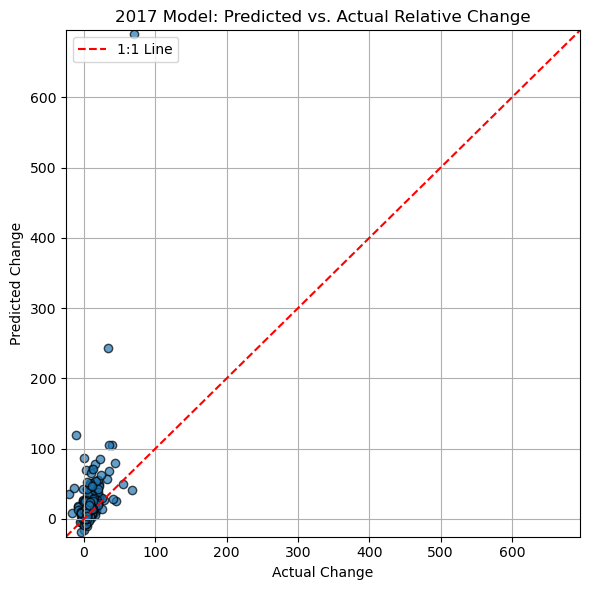

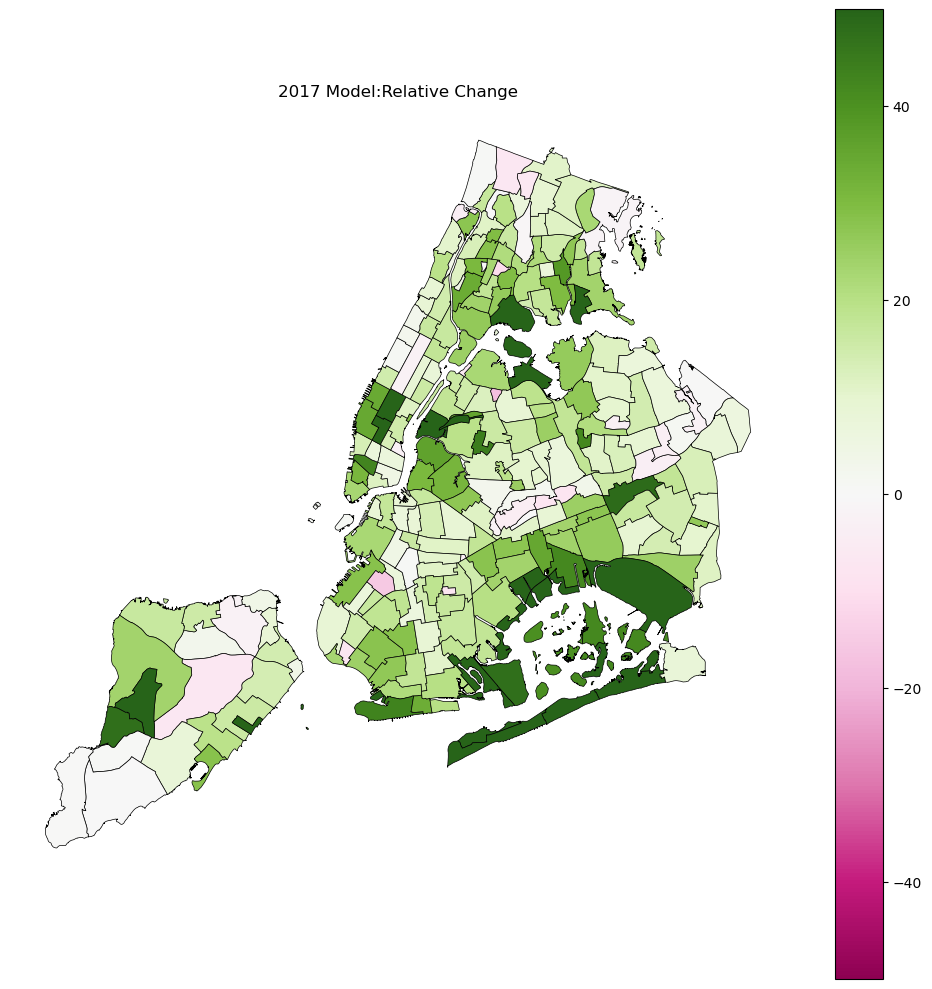

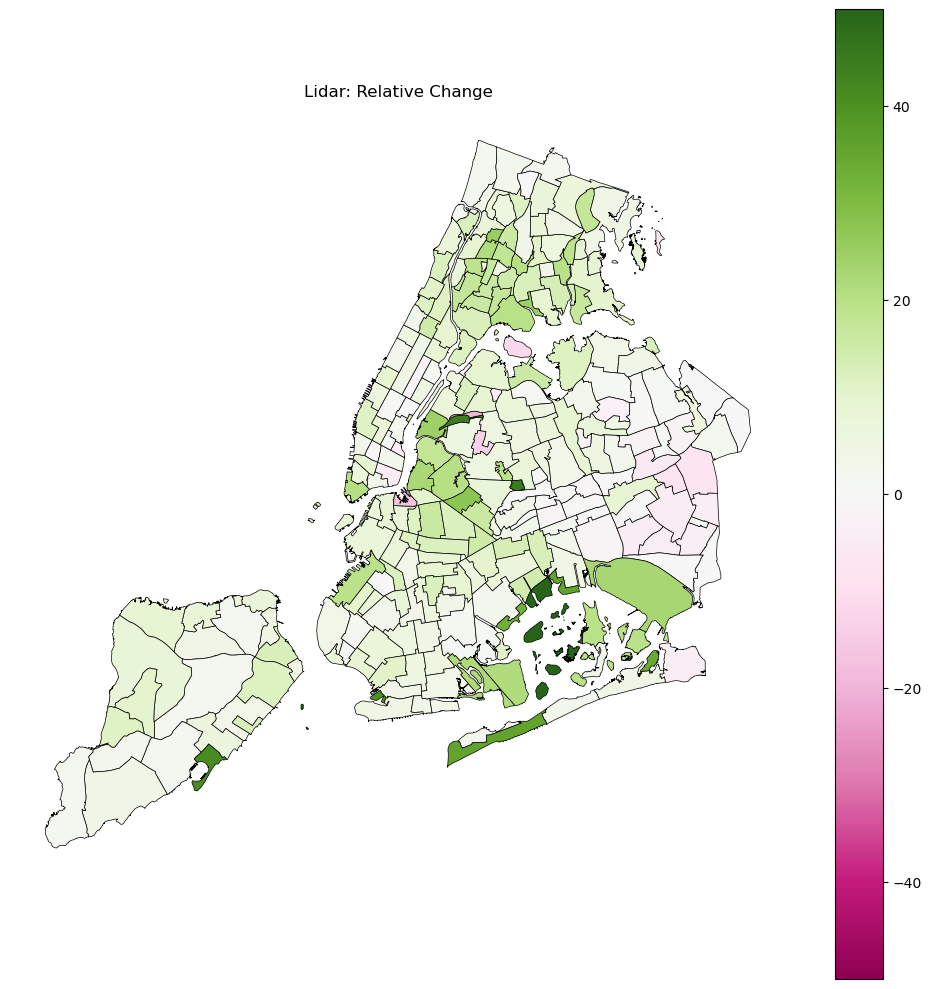

In [87]:
plot_relative_change('nta', '2017 Model', train='nyc17',test='nyc17')

In [77]:
m['actual_relative_change'].max()

np.float64(70.56325730945312)

In [40]:
def plot_aggregated(bound,model):
        
        gdf1 = gpd.read_file(root / 'output' / 'gpkg' / f'{model}_{bound}_change.gpkg')
        gdf2 = gpd.read_file(root / 'output' / 'gpkg' / f'Lidar_{bound}_change.gpkg')

        merge_col = 'nta2020' if bound == 'nta' else 'BoroCD'

        gdf = gdf1.merge(gdf2,on=merge_col)

        title = 'NTA' if bound == 'nta' else 'Community District'

        x = gdf['Lidar_change']
        y = gdf[f'{model}_change']

        min_lim = min(min(y), min(x)) - 5
        max_lim = max(max(x),max(y)) + 5

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.7, edgecolor='k')
        plt.plot([min_lim,max_lim], [min_lim,max_lim], color='red', linestyle='--', label='1:1 Line')  # AB line

        plt.xlabel('Actual Change')
        plt.ylabel('Predicted Change')
        plt.title(f'{model}: {title} Predicted vs. Actual Change 2017 - 2021')
        plt.xlim(min_lim,max_lim)
        plt.ylim(min_lim,max_lim)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(root / 'output' / 'png' / f'abplot_change_{bound}_{model}.png')

In [45]:
#diffs_2017model = xr.open_dataarray(root / 'output' / 'tif' / 'diffs_2017model.tif')
#diffs_2021model = xr.open_dataarray(root / 'output' / 'tif' / 'diffs_2021model.tif')
diffs_actual = xr.open_dataarray(root / 'output' / 'tif' / 'actual_diff_2017_2021.tif')

In [ ]:
agg_change_nta_cd(diffs_actual,'Lidar')

In [46]:
def agg_change_nta_cd(change_raster,model, title='Change 2017 - 2021'):
       
        
        nta_gdf = gpd.read_file(root / 'data' / 'nyc' / 'nyc_nta.shp')
        nta_gdf = nta_gdf.to_crs(change_raster.rio.crs)
        cd_gdf = gpd.read_file(root / 'data' / 'nyc' / 'nyc_commdist.gpkg')
        cd_gdf = cd_gdf.to_crs(change_raster.rio.crs)
    

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

            canopy_percent_list = []

            for _, row in bound.iterrows():
                geom = [mapping(row.geometry)]

                    # Create a mask for pixels inside the polygon
                mask = geometry_mask(geom,
                                    transform=change_raster.rio.transform(),
                                    invert=True,
                                    out_shape=(change_raster.shape[-2], change_raster.shape[-1]))

                # Extract canopy values within the polygon
                canopy_vals = np.where(mask, change_raster.values, np.nan)
                canopy_vals = canopy_vals / 100

                # Calculate area covered by canopy (as percent * pixel area)
                canopy_area_m2 = np.nansum(canopy_vals * 900)

                # Total area of polygon in m²
                polygon_area_m2 = row.geometry.area

                    # Percent of polygon covered by canopy
                percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                canopy_percent_list.append(percent_cover)


            bound[f"{model}_change"] = canopy_percent_list

                
            bound.plot(column=f'{model}_change',
            cmap='PiYG',
            legend=True,
            vmin=-10,
            vmax=10,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))


            plt.title(f"{model}:{title}")
            plt.axis('off')
            plt.tight_layout()

            if not os.path.exists(root / 'output' / 'png'):
                os.makedirs(root / 'output' / 'png')
            plt.savefig(root / 'output' / 'png' / f'{model}_{bound_name}_change.png')

            if not os.path.exists(root / 'output' / 'gpkg'):
                os.makedirs(root / 'output' / 'gpkg')

            bound.to_file(root / 'output' / 'gpkg' / f'{model}_{bound_name}_change.gpkg')



In [ ]:
map_change(save=True)

In [ ]:
nycpred = CanopyPredictionsDev.from_npz(root / 'output' / 'npz' / 'result_obj_train_nyc17_test_nyc21v3_nyc17_twostage_class1prob08_nonstratified10pct_thresh02.pkl.npz')
nycpred.map_predictions(save=True)
nycpred.aggregate_and_plot(res_list=[30,90, 120, 150, 180, 210, 240, 270, 300],save_plot=True)
nycpred.agg_nta_cd()
nycpred.plot_aggregated('nta')
nycpred.plot_aggregated('cd')

In [ ]:
# make aggregated plots for saved results

train = 'nyc21v3'
test = 'nyc21v3'

nycpred = CanopyPredictionsDev.from_npz(root / 'output' / 'npz' / f'result_obj_train_{train}_test_{test}_{train}_twostage_class1prob08_nonstratified10pct_thresh02.pkl.npz')
nycpred.map_predictions(save=True)
nycpred.agg_nta_cd()
nycpred.nta_gdf.to_file(root / 'output' / 'gpkg' / f'nta_train_{train}_test_{test}.gpkg')
nycpred.cd_gdf.to_file(root / 'output' / 'gpkg' / f'cd_train_{train}_test_{test}.gpkg')

In [ ]:
from sklearn.linear_model import LinearRegression

import matplotlib.patches as mpatches

def residuals_scatterplot(df,x_col = 'actual_tc',y_col = 'residual',title='Actual TC vs. Residuals'):

    df.plot(x=x_col,y=y_col,kind='scatter',s=5)
    plt.axhline(y=0,color='red',linestyle='--',linewidth=1)
    plt.ylim(-100,100)

    # legend_patches = [mpatches.Patch(color=clr, label=cls) for cls, clr in color_dict.items()]
    # plt.legend(handles=legend_patches, title=legend_title,loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.title(title)
    plt.xlabel('% Tree Canopy')
    plt.ylabel('Residual')

    plt.tight_layout()

    filename = title.replace('=','_').replace(' ','_')
    plt.savefig(root/'output'/'nyc'/f'residuals_scatterplot_{filename}.png')

def residuals_boxplot(df1,rmse,title,x_col='residual'):
    
    plt.figure(figsize=(9,5))
    sns.boxplot(data=df1,y='landcover_label',x=x_col,hue='colors',showfliers=False,legend=False)

    plt.title(f'Residuals by Landcover: {title}, RMSE: {rmse}')
    plt.xlabel('Residual (predicted - actual)')
    plt.ylabel('Landcover Type')
    plt.axvline(x=0,color='red',linestyle='--',linewidth=1)
    plt.xlim(-50,50)
    #plt.xticks(ticks=np.arange(-50, 55, 10)) 
    
    plt.tight_layout()

    filename = title.replace('=','_').replace(' ','_')
    plt.savefig(root/'output'/'nyc'/f'residuals_boxplot_{filename}.png')

def format_result_df(df1,wetland=False,nac=False):
    df = df1.copy()

    if df['predicted_tc'].max() <= 1.0:
        df['predicted_tc'] = df['predicted_tc']*100
    if df['actual_tc'].max() <= 1.0:
        df['actual_tc'] = df['actual_tc']*100

    if wetland:
        df['landcover'] = df['landcover'].replace({1.0:6.0,4.0:6.0})
        landcover_map = {0:'Emergent',
                        5:  'Estuarine',
                        6: 'Upland'}
        df['landcover_label'] = df['landcover'].map(landcover_map)
        lc_classes = df['landcover_label'].unique()
        colors = plt.get_cmap('tab10')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}
        df['colors'] = df['landcover_label'].map(color_dict)
    elif nac:
        # landcover_map = {1.0: 'Bare Soil',2.0: 'Building',3.0: 'Forested Wetland',6.0: 'Maintained Lawn/Shrub',7.0: 'Maritime Forest',8.0: 'Other Paved Surface',9.0: 'Other Tree Canopy',11.0: 'Inland Water',12.0: 'Road/Railroad',14.0: 'Wetlands',15.0: 'Upland Forest',16.0: 'Upland Grass/Shrub'}
        
        landcover_map = {1.0: 'Bare Soil',2.0: 'Building',6.0: 'Maintained Lawn/Shrub',8.0: 'Other Paved Surface',9.0: 'Other Tree Canopy',11.0: 'Inland Water',12.0: 'Road/Railroad',14.0: 'Wetlands',15.0: 'Forest',16.0: 'Upland Grass/Shrub'}
        
        df['landcover_label'] = df['landcover'].map(landcover_map)
        lc_classes = df['landcover_label'].unique()
        colors = plt.get_cmap('tab20')
        color_dict = {cl:color for cl, color in zip(lc_classes,list(colors.colors))}
        df['colors'] = df['landcover_label'].map(color_dict)

    else:
        # nlcd
        df['landcover'] = df['landcover'].replace({81: 21,82: 21,43: 41,42: 41,52:71}) 
        landcover_map = {
            21: 'Developed, Open Space',
            22: 'Developed, Low Intensity',
            23: 'Developed, Medium Intensity',
            24: 'Developed, High Intensity',
            41: 'Forest',
            31: 'Barren Land',
            71: 'Non-tree Vegetation',
            90: 'Woody Wetlands',
            95: 'Herbaceous Wetlands'
        }


        df['landcover_label'] = df['landcover'].map(landcover_map)

    df['residual'] = df['actual_tc'] - df['predicted_tc'] 

    df = df.sort_values(by='landcover')

    # apply linear correction
    prediction = df['predicted_tc'].values
    residuals = df['residual']

    correction_model = LinearRegression().fit(prediction.reshape(-1, 1), residuals)
    print(correction_model.coef_)

    df['adjusted_preds'] = df['predicted_tc'] + correction_model.predict(prediction.reshape(-1, 1))

    adjusted_rmse = root_mean_squared_error(df['actual_tc'],df['adjusted_preds'])

    df['adjusted_residual'] = df['actual_tc'] - df['adjusted_preds']
    
    return df, adjusted_rmse, color_dict

In [ ]:
# compare gradient boost model

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

models = {
    "Random Forest": RandomForestRegressor(
        min_samples_leaf=5, random_state=0, n_jobs=N_CORES
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_leaf_nodes=15, random_state=0, early_stopping=False
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500]},
}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X, y)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

    

In [ ]:
### model dev

nyc_mod = ModelBuilder(root=root,train_site=nyc21v3,test_site_list=[nyc24])

vars = ['april','july','october','springdiff']
# test_df, rmse= nyc_mod.test_regression_models(model_name='randomforest',var_selection_threshold=None,vars_to_use=vars,sample_frac=0.02,k_folds=5,n_iter=30,tune_params=False,grouped=True) 
#test_df, rmse, countsdf = nyc_mod.test_model_grouped_sampling(model_name='randomforest',vars_to_use=vars,samples_per_class=6000)
# test_df, rmse = nyc_mod.test_model_seperate_wetland_sample(model_name='randomforest',k_folds=5,sample_frac=0.05,vars_to_use=None,var_selection_threshold=0.2)

# test_df, rmse = nyc_mod.test_model_nac(model_name='ranodomforest',vars_to_use=vars,var_selection_threshold=None,seed=42,frac=0.05,n=None,k_folds=5,num_trees=100,random_state=42)
# test_df, rmse = nyc_mod.tune_regression_models(model_name='randomforest',lc_cats='nac',vars_to_use=vars,var_selection_threshold=None,frac=0.05,k_folds=5,random_state=42,n_iter=30)

# nyc_pred = nyc_mod.predict_with_tuned_model(model_name='randomforest',lc_cats='wetland',autoselect_variables=False,transfer_results=True,local_results=True,var_selection_threshold=0.2,frac=0.1,model_filename='nyc_rf_wetland10pctsample_thresh02.pkl',load_saved=True)


nyc_pred = nyc_mod.predict_with_two_stage_model(transfer_results=True,local_results=False,class_1_threshold=0.8,autoselect_variables=True,manual_variables=False,vars_to_use=None,var_selection_threshold=0.2,frac=0.10,random_state=42,test_size=0.3,model_filename='nyc21v3_twostage_class1prob08_nonstratified10pct_thresh02.pkl',load_saved=True, stratified=False)

### Tune Hyperparams

In [ ]:
df_sample = df.sample(frac=0.08,replace=False)

X = df_sample.drop('canopy',axis=1)
X = X.loc[:,october]
y = df_sample['canopy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape

In [ ]:
param_keys = ['model__max_features','model__max_samples', 'model__min_samples_leaf',
            'model__min_samples_split','model__n_estimators','rmse']
# create empy dict to hold grid search results
param_dict = {'model__max_features':[],'model__max_samples':[], 'model__min_samples_leaf':[],
            'model__min_samples_split':[],'model__n_estimators':[],'train_rmse':[],'test_rmse':[]}

def get_top_params(model):

    params = model.best_estimator_.get_params()
    #params2 = {x: [params[x]] for x in param_keys}
    params = [params.get(x) for x in param_keys]

    i = 0
    for key in param_keys[:-1]:
        param_dict[key].append(params[i])
        i += 1
    
    
    param_dict['test_rmse'].append(model.score(X_test,y_test))
    param_dict['train_rmse'].append(model.best_score_)

    
    return print('parameters added to param_dict')

In [ ]:
pipe = Pipeline([
    ('model', RandomForestRegressor())
    ])

#pipe.get_params()

mod = GridSearchCV(estimator=pipe,
             cv=5,
             scoring={'rmse': make_scorer(root_mean_squared_error)},
             refit='rmse', # optimize based on rmse not r2
             param_grid={'model__ccp_alpha': [0.0],
                        'model__criterion': ['squared_error'],
                        'model__max_depth': [None],
                        'model__max_features': ['sqrt'],
                        'model__max_leaf_nodes': [None],
                        'model__max_samples': [0.1],
                        'model__min_impurity_decrease': [0.0],
                        'model__min_samples_leaf': [300],
                        'model__min_samples_split': [50],
                        'model__min_weight_fraction_leaf': [0.0],
                        'model__monotonic_cst': [None],
                        'model__n_estimators': [1000],
                        'model__n_jobs': [None],
                        'model__oob_score': [False]
                        })


mod.fit(X_train,y_train)

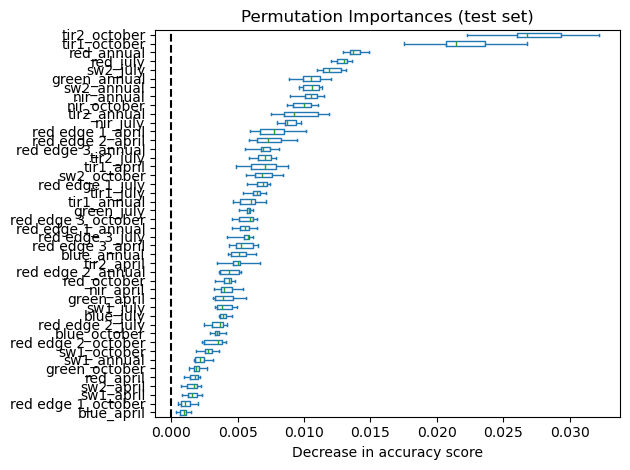

In [ ]:
# variable importance

from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()